## Imports and simulation setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
import scipy.io
from time import sleep, process_time
import sys
import os

sim.ResetKernel()

mins = 10.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')
sim.local_num_threads = 8 # NEST recommends 1 thread per core

# 'simulate': Run on NEST to generate results, this will save the results to .npy files
# 'load': Load a prior run without running the NEST simulator

simulate_or_load = 'simulate'

# 'spiral': Generate a spiral trajectory
# 'rat': Load one or more Sargolini datasets from file

spiral_or_rat = 'rat'
concatenate_rat = False

[INFO] [2023.3.17 18:25:35 /home/conda/feedstock_root/build_artifacts/nest-simulator_1580129125463/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2023.3.17 18:25:35 /home/conda/feedstock_root/build_artifacts/nest-simulator_1580129125463/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.18.0
 Built: Jan 27 2020 12:49:15

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

simulation length: 10.0 mins = 600000 ms

Mar 17 18:25:36 ModelManager::clear_models_ [Info]: 
    Models will be cleared and parameters reset.

Mar 17 18:25:36 Network::create_rngs_ [Info]: 
    Deleting existing random number generators

Mar 17 18:25:36 Network::create_rngs_ [Info]: 

In [2]:
# Population cell counts

# N_ex: number of cells in the excitatory rings
# N_in: number of cells in the inhibitory rings
# N_cj: number of cells in the conjunctive rings
# rings: number of mono-axis rings ('directional rings')
# omni_rings: number of axis-invariant rings ('speed rings')
# window_size: how large a window of excitatory ring cells is each principle axis cell sensitive to?
# N_pa_cells_per_ring: how many PA cells exist for each ring (more = finer binning of excitatory ring activity)
# N_pyramidals: how many pyramidal cells are there?

N_ex = 120
N_in = N_ex
N_cj = N_ex

rings = 3
omni_rings = 0

window_size = 20

N_pa_cells_per_ring = N_ex // window_size

N_pyramidals = N_pa_cells_per_ring ** rings

tension = True

minimum_input = 2000#2000#1000

# Connection Gaussian weight parameters

# sigma: variance for excitatory ring -> inhibitory ring weight Gaussian
# in_sigma: variance for inhibitory ring -> excitatory ring weight Gaussian
# in_cj_sigma: variance for inhibitory ring -> conjunctive rings weight Gaussian
# mu: mean offset of Gaussians (when used)
# prune_smaller_than: weights below this threshold will become 0, effectively removing the connection

sigma = 0.1
in_sigma = 0.05
in_cj_sigma = 0.1#0.08#0.09#0.08 # was at about 1-1.02 before, when coming back to this, give these a try
mu = 0.5
prune_smaller_than = 10

smooth_sigma = 10

# Connection scalar weight parameters. These are signed as appropriate later on

# base_ex: excitatory ring -> inhibitory ring weight strength (+)
# base_in: inhibitory ring -> excitatory ring weight strength (-)
# base_cj: conjunctive rings -> excitatory rings weight strength (+)
# w_ex_cj: excitatory rings -> conjunctive rings weight strength (+)
# w_in_cj: inhibitory_rings -> conjunctive rings weight strength (-)
# w_ex_pa: excitatory_rings -> principle axis cells weight strength (+)
# w_pa_py: principle axis cells -> pyramidal cells weight strength (+)

# Spiral settings:

# base_ex = 5000
# base_in = 1500
# base_cj = 500
# w_ex_cj = 440
# w_in_cj = 1800 # Was about 800 before, put up a lot higher before velocity calculation was changed to properly share out input
# w_ex_pa = 300
# w_pa_py = 200

# Rat settings:

# Next week: dropping inhibition is helping with integrating small velocities, try to lower it further and lower excitation too if needs be

base_ex = 3500#4000#5000
base_in = 0#1500
base_cj = 500
w_ex_cj = 0
w_in_cj = 5750#3250#3500#4000#4500#3600#1700#700 # Was about 800 before, put up a lot higher before velocity calculation was changed to properly share out input
w_ex_pa = 100#80
w_pa_py = 300
w_ex_in_pa = w_ex_pa
w_in_pa_in_py = w_pa_py

cj_in_offset = 0 # Is the inhibitory 'bowl' biased towards the direction of input? If so, by how many cells?

# Synaptic transmission delay (I believe this includes the synapse proper and action potential travel time)

delay = 0.1 

# Velocity scaling parameters

# I_vel: multiply incoming velocity by this amount to get the input current representing the vestibular signal
# velocity_threshold: Are very small values for velocity set to zero?
# miniumum_velocity: What is the minimum non-zero velocity? (only works if velocity_threshold is True)

I_vel = 700000#1400#800 # Seems to work best if you can get the velocities in a 0-4000 range

# Are conjuctive cells synapsed onto by excitatory layer or inhibitory layer.

# 'positive': scalar excitatory weight, conjunctive weights must be tuned to act as a coincidence detector for input velocity and bump activity
# 'negative': Gaussian inhibitory weight, suppresses incoming velocity input too far from the attractor bump
# 'both': inhibitory 'bowl' as per 'negative' and self-reinforcing excitatory connections

conjunctive_mode = 'negative'

# Intrinsic excitation of the excitatory ring, constant current in picoamps

intrinsic_excitation = 0.#225.

theta = False

# Initial (bump-forming) current injection parameters. This is a short spike of input to form the initial attractor state, to be adjusted by conjunctive input

# I_init: strength of input current in picoamps
# I_init_dur: how long this is applied for, in milliseconds
# I_init_pos: where is this applied, in ring index (1-120). NEST, for better or worse, has neuron IDs starting at 1

I_init = 300.0
I_init_dur = 100.0
I_init_pos = N_ex//2

## Create neuron populations from the above parameters

In [3]:
# Lists to store each ring's population

exc = []
inh = []
l = []
r = []
pa_cells = []
input_pa_cells = []

for i in range(rings):
    
    if intrinsic_excitation > 0:

        exc.append(sim.Create("iaf_psc_alpha",N_ex, params={"I_e": intrinsic_excitation})) # Excitatory layer, with intrinsic activity
        
    else:
        
        exc.append(sim.Create("iaf_psc_alpha",N_ex))
        
    inh.append(sim.Create("iaf_psc_alpha",N_in)) # Inhibitory layer

    l.append(sim.Create("iaf_psc_alpha",N_cj)) # Conjunctive layer for left turn
    r.append(sim.Create("iaf_psc_alpha",N_cj)) # Conjunctive layer for right turn
    
    pa_cells.append(sim.Create("iaf_psc_alpha",N_pa_cells_per_ring))
    
    input_pa_cells.append(sim.Create("iaf_psc_alpha",N_pa_cells_per_ring))
    
# The pyramidal cells associate across rings    

pyramidal_cells = sim.Create("iaf_psc_alpha",N_pyramidals)

input_grid_devices = sim.Create('step_current_generator',N_pyramidals)

In [4]:
## Define connection weight matrices

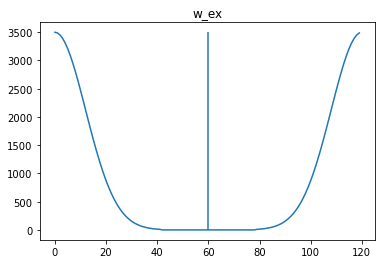

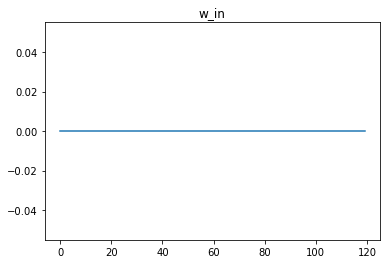

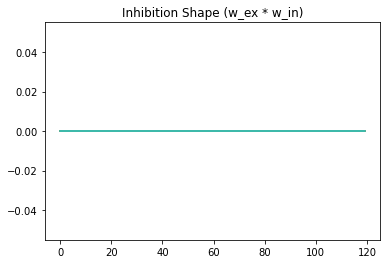

In [5]:
# Empty matrices

w_ex = np.empty((N_in,N_ex))
w_in = np.empty((N_ex,N_in))

for e in range(N_ex):
    for i in range(N_in):
        # Find minimum (true) distance between adjacent cells
        d1 = abs(e/N_ex - i/N_in)
        d2 = abs(e/N_ex - i/N_in -1)
        d3 = abs(e/N_ex - i/N_in +1)
        d = min(abs(d1),abs(d2),abs(d3))
        # Create gaussian value based on parameters above to define connection strengths
        w_gauss = np.exp(-(d - mu)**2/2/sigma**2) # Exitatory -> inhibitory
        w_ring = np.exp(-(d)**2/2/in_sigma**2) # Inhibitory -> excitatory
        # Assign appropriate weight values to matrices
        w_ex[i,e] = base_ex * w_gauss
        w_in[e,i] = base_in * w_ring 
    
# Very small weights become 0

w_ex[w_ex<prune_smaller_than] = 0
w_in[w_in<prune_smaller_than] = 0

# Plot weight matrix interactions as a sanity check. Should be an 'arch' of inhibition, leaving the suppressing areas far from the injection site

intrinsic_input = np.tile(450., N_ex)

injection_site = I_init_pos

plt.plot(w_ex[injection_site, :])
plt.vlines(injection_site, 0, np.max(w_ex))
plt.title("w_ex")
plt.show()

plt.plot(-w_in[0, :])
plt.vlines(injection_site, 0, np.min(-w_in))
plt.title("w_in")
plt.show()

plt.plot(w_ex[injection_site, :] * -w_in[:, :])
plt.vlines(injection_site, 0, np.min(w_ex[injection_site, :] * -w_in))
plt.title("Inhibition Shape (w_ex * w_in)")
plt.show()

In [6]:
# As before, connection weight matrices, this time between conjunctive layers and the excitatory layer

w_l = np.empty((N_ex,N_cj))
w_r = np.empty((N_ex,N_cj))

for c in range(N_cj):  
    for e in range(N_ex):
        # Minimum distance, this time between each conjunctive cell and the excitatory cell displaced 1 away (e +/- 1)
        # Left is anticlockwise, therefore drives the cell immediately to the left
        # Right is clockwise, therefore drives the cell immediately to the right
        d1 = abs((e-1)/N_cj - c/N_ex)
        d2 = abs((e-1)/N_cj - c/N_ex -1)
        d3 = abs((e-1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_l[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
        d1 = abs((e+1)/N_cj - c/N_ex)
        d2 = abs((e+1)/N_cj - c/N_ex -1)
        d3 = abs((e+1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_r[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))

# Set all not the max to zero; makes sure the conjunctive cells only drive the immediate neighbour
# Still uses the Gaussian connection weight, just doesn't use the whole Gaussian (for now)

m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0

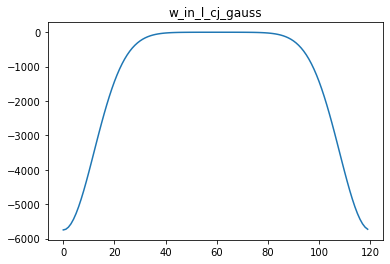

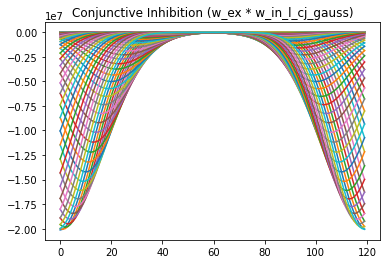

In [7]:
# Gaussian weight matrix for inhibitory->left conjunctive cells (if conjuctive_mode == 'negative')

w_in_l_cj_gauss = np.empty((N_cj,N_in))

for i in range(N_in):
    for c in range(N_cj):  
        # Minimum distance, this time between each conjunctive cell and the excitatory cell displaced 1 away (e +/- 1)
        # Left is anticlockwise, therefore drives the cell immediately to the left
        # Right is clockwise, therefore drives the cell immediately to the right
        d1 = abs((c-cj_in_offset)/N_cj - i/N_in)
        d2 = abs((c-cj_in_offset)/N_cj - i/N_in -1)
        d3 = abs((c-cj_in_offset)/N_cj - i/N_in +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_in_l_cj_gauss[c,i] = w_in_cj * (np.exp(-(d)**2/2/in_cj_sigma**2))
        
w_in_l_cj_gauss = w_in_l_cj_gauss# - np.max(w_in_cj_gauss)

plt.plot(-w_in_l_cj_gauss[0, :])
plt.title("w_in_l_cj_gauss")
plt.show()

plt.plot( w_ex[injection_site, :] * -w_in_l_cj_gauss[:, :])
plt.title("Conjunctive Inhibition (w_ex * w_in_l_cj_gauss)")
plt.show()

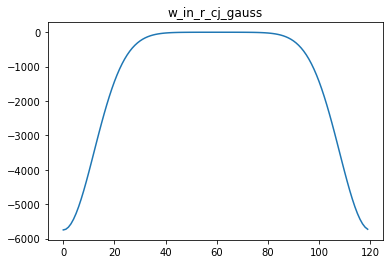

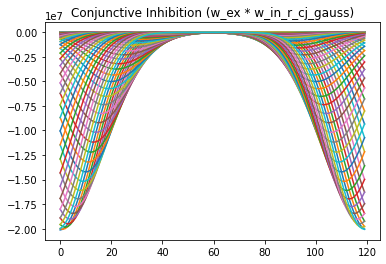

In [8]:
# Gaussian weight matrix for inhibitory->right conjunctive cells (if conjuctive_mode == 'negative')

w_in_r_cj_gauss = np.empty((N_cj,N_in))

for i in range(N_in):
    for c in range(N_cj):  
        # Minimum distance, this time between each conjunctive cell and the excitatory cell displaced 1 away (e +/- 1)
        # Left is anticlockwise, therefore drives the cell immediately to the left
        # Right is clockwise, therefore drives the cell immediately to the right
        d1 = abs((c+cj_in_offset)/N_cj - i/N_in)
        d2 = abs((c+cj_in_offset)/N_cj - i/N_in -1)
        d3 = abs((c+cj_in_offset)/N_cj - i/N_in +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_in_r_cj_gauss[c,i] = w_in_cj * (np.exp(-(d)**2/2/in_cj_sigma**2))
        
w_in_r_cj_gauss = w_in_r_cj_gauss# - np.max(w_in_cj_gauss)

#w_in_cj_gauss[w_in_cj_gauss<(-250)]=-250
        
#for i in range(len(w_in_cj_gauss)):
#    print(w_in_cj_gauss[i, :])
    
plt.plot(-w_in_r_cj_gauss[0, :])
plt.title("w_in_r_cj_gauss")
plt.show()

plt.plot( w_ex[injection_site, :] * -w_in_r_cj_gauss[:, :])
plt.title("Conjunctive Inhibition (w_ex * w_in_r_cj_gauss)")
plt.show()

## Wire everything up

In [9]:
for i in range(rings):

    # Excitatory and inhibitory set to connect all to all, using the prior calculated weight matrix

    exc_2_inh = sim.Connect(exc[i],inh[i],'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
    inh_2_exc = sim.Connect(inh[i],exc[i],'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})
    
    # Conjunctive layers connecting to the excitatory layer, with weights

    l_2_exc = sim.Connect(l[i],exc[i],'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
    r_2_exc = sim.Connect(r[i],exc[i],'all_to_all',syn_spec={'weight': w_r, 'delay': delay})
    
    if conjunctive_mode == 'positive':

        # Excitatory connecting one-to-one to both conjuntive layers, with fixed weight.  A 'coincidence detector'.

        exc_2_l = sim.Connect(exc[i],l[i],'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
        exc_2_r = sim.Connect(exc[i],r[i],'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

    elif conjunctive_mode == 'negative':

        # Inhibitory connecting one-all_to_all-one to both conjuntive layers, with inverse Gaussian weights

        inh_2_l = sim.Connect(inh[i],l[i],'all_to_all',syn_spec={'weight': -w_in_l_cj_gauss, 'delay': delay})
        inh_2_r = sim.Connect(inh[i],r[i],'all_to_all',syn_spec={'weight': -w_in_r_cj_gauss, 'delay': delay})
        
    elif conjunctive_mode == 'both':

        exc_2_l = sim.Connect(exc[i],l[i],'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
        exc_2_r = sim.Connect(exc[i],r[i],'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

        inh_2_l = sim.Connect(inh[i],l[i],'all_to_all',syn_spec={'weight': -w_in_l_cj_gauss, 'delay': delay})
        inh_2_r = sim.Connect(inh[i],r[i],'all_to_all',syn_spec={'weight': -w_in_r_cj_gauss, 'delay': delay})

## Wire everything up

In [10]:
# Connect a N-wide window of the ring to each principle axis cell

import random

windows = []

for ring in exc:

    for i in range(0, N_ex, window_size):
    
        window = ring[i:i+window_size]
        
        windows.append(window)

for i in range(rings):
    
    for j in range(N_pa_cells_per_ring):
    
        sim.Connect(windows[i*N_pa_cells_per_ring+j], [pa_cells[i][j]],'all_to_all',syn_spec={'weight': w_ex_pa, 'delay': delay})
        
for i in range(rings):
    
    for j in range(N_pa_cells_per_ring):
    
        sim.Connect([input_pa_cells[i][j]], windows[i*N_pa_cells_per_ring+j],'all_to_all',syn_spec={'weight': w_ex_in_pa, 'delay': delay})

In [11]:
# Iterate through each and every combination of the ring neurons ([1,1,1], [1,1,2] ... [N, N, N]), assigning each trio to a pyramidal cell
# When all is said and done, this acts like a 3-digit, base-12 number, with each digit representing a ring

import pandas as pd

total_pa_cells = N_pa_cells_per_ring * rings

cell_indices = np.zeros(shape = (N_pyramidals))
target_cells = np.zeros(shape = (N_pyramidals))
source_pa_cells = np.zeros(shape = (rings, N_pyramidals))
source_pa_cell_indices = np.zeros(shape = (rings, N_pyramidals))

in_range = True

for r1 in (x for x in range(N_pa_cells_per_ring) if in_range is True): # Ring 1

    for r2 in (y for y in range(N_pa_cells_per_ring) if in_range is True): # Ring 2

        for r3 in (z for z in range(N_pa_cells_per_ring) if in_range is True): # Ring 3

            cell_index = (r1 * N_pa_cells_per_ring ** 2) + (r2 * N_pa_cells_per_ring) + r3 # Steps from 0 to max
            
            if cell_index != N_pyramidals:

                target_cell = pyramidal_cells[cell_index]

                sim.Connect([pa_cells[0][r1]], [target_cell],'all_to_all',syn_spec={'weight': w_pa_py, 'delay': delay})
                sim.Connect([pa_cells[1][r2]], [target_cell],'all_to_all',syn_spec={'weight': w_pa_py, 'delay': delay})
                sim.Connect([pa_cells[2][r3]], [target_cell],'all_to_all',syn_spec={'weight': w_pa_py, 'delay': delay})

                # Gather up data for Pandas, to be used later in grid cell evalutation
                
                cell_indices[cell_index] = cell_index
                target_cells[cell_index] = target_cell
                source_pa_cells[0][cell_index] = pa_cells[0][r1]
                source_pa_cells[1][cell_index] = pa_cells[1][r2]
                source_pa_cells[2][cell_index] = pa_cells[2][r3]
                source_pa_cell_indices[0][cell_index] = r1
                source_pa_cell_indices[1][cell_index] = r2
                source_pa_cell_indices[2][cell_index] = r3
                
            else:
                
                in_range = False
                
pa_to_pyramidal_connections = pd.DataFrame({'Target Cell Index': cell_indices,
                                            'Target Pyramidal Cell': target_cells,
                                            'Ring 1 Index': source_pa_cell_indices[0],
                                            'Ring 2 Index': source_pa_cell_indices[1],
                                            'Ring 3 Index': source_pa_cell_indices[2],
                                            'Ring 1 PA Cell': source_pa_cells[0],
                                            'Ring 2 PA Cell': source_pa_cells[1],
                                            'Ring 3 PA Cell': source_pa_cells[2],})

print(pa_to_pyramidal_connections)

     Target Cell Index  Target Pyramidal Cell  Ring 1 Index  Ring 2 Index  \
0                  0.0                 1477.0           0.0           0.0   
1                  1.0                 1478.0           0.0           0.0   
2                  2.0                 1479.0           0.0           0.0   
3                  3.0                 1480.0           0.0           0.0   
4                  4.0                 1481.0           0.0           0.0   
..                 ...                    ...           ...           ...   
211              211.0                 1688.0           5.0           5.0   
212              212.0                 1689.0           5.0           5.0   
213              213.0                 1690.0           5.0           5.0   
214              214.0                 1691.0           5.0           5.0   
215              215.0                 1692.0           5.0           5.0   

     Ring 3 Index  Ring 1 PA Cell  Ring 2 PA Cell  Ring 3 PA Cell  
0      

In [12]:
# Now do the same but in the opposite direction; assign each unique combination of RP cells an incoming 'grid input cell'
# that can be driven by external input cues

# For convenience, and to save modelling an extra population of 'pass through' cells, input devices current synapse directly onto the 
# excitatory ring, at the midpoint of the RP receptive field

# The non-existent input RP cells are given here as placeholders, for managing input to the ring in the format plausible for 
# downstream brain areas to be aware of; it is assumed that the state of the rings themselves is too granular

import pandas as pd

total_pa_cells = N_pa_cells_per_ring * rings

source_cell_indices = np.zeros(shape = (N_pyramidals))
source_cells = np.zeros(shape = (N_pyramidals))
target_ring_cells = np.zeros(shape = (rings, N_pyramidals))
target_ring_cell_indices = np.zeros(shape = (rings, N_pyramidals))
target_virtual_rp = np.zeros(shape = (rings, N_pyramidals))

in_range = True

for r1 in (x for x in range(N_pa_cells_per_ring) if in_range is True): # Ring 1

    for r2 in (y for y in range(N_pa_cells_per_ring) if in_range is True): # Ring 2

        for r3 in (z for z in range(N_pa_cells_per_ring) if in_range is True): # Ring 3

            source_cell_index = (r1 * N_pa_cells_per_ring ** 2) + (r2 * N_pa_cells_per_ring) + r3 # Steps from 0 to max
            
            if cell_index != N_pyramidals:

                source_cell = input_grid_devices[source_cell_index]
                
                target_cell_index_r1 = (r1 + 1) * window_size - (window_size // 2) - 1
                target_cell_index_r2 = (r2 + 1) * window_size - (window_size // 2) - 1
                target_cell_index_r3 = (r3 + 1) * window_size - (window_size // 2) - 1
                
                target_cell_r1 = exc[0][target_cell_index_r1]
                target_cell_r2 = exc[1][target_cell_index_r2]
                target_cell_r3 = exc[2][target_cell_index_r3]
                
                sim.Connect([source_cell], [target_cell_r1], 'all_to_all', syn_spec={'weight': w_in_pa_in_py, 'delay': delay})
                sim.Connect([source_cell], [target_cell_r2], 'all_to_all', syn_spec={'weight': w_in_pa_in_py, 'delay': delay})
                sim.Connect([source_cell], [target_cell_r3], 'all_to_all', syn_spec={'weight': w_in_pa_in_py, 'delay': delay})

                # Gather up data for Pandas, to be used later in grid cell evalutation
                
                source_cell_indices[source_cell_index] = source_cell_index
                source_cells[source_cell_index] = source_cell
                target_virtual_rp[0][source_cell_index] = r1
                target_virtual_rp[1][source_cell_index] = r2
                target_virtual_rp[2][source_cell_index] = r3
                target_ring_cells[0][source_cell_index] = target_cell_r1
                target_ring_cells[1][source_cell_index] = target_cell_r2
                target_ring_cells[2][source_cell_index] = target_cell_r3
                target_ring_cell_indices[0][source_cell_index] = target_cell_index_r1
                target_ring_cell_indices[1][source_cell_index] = target_cell_index_r2
                target_ring_cell_indices[2][source_cell_index] = target_cell_index_r3
                
            else:
                
                in_range = False
                
input_device_to_ring_cells_connections = pd.DataFrame({ 'Source Device Index': source_cell_indices,
                                                        'Source Device': source_cells,
                                                        'Ring 1 Virtual RP' : target_virtual_rp[0],
                                                        'Ring 2 Virtual RP' : target_virtual_rp[1],
                                                        'Ring 3 Virtual RP' : target_virtual_rp[2],
                                                        'Ring 1 Index': target_ring_cell_indices[0],
                                                        'Ring 2 Index': target_ring_cell_indices[1],
                                                        'Ring 3 Index': target_ring_cell_indices[2],
                                                        'Ring 1 Cell': target_ring_cells[0],
                                                        'Ring 2 Cell': target_ring_cells[1],
                                                        'Ring 3 Cell': target_ring_cells[2],})

print(input_device_to_ring_cells_connections)

     Source Device Index  Source Device  Ring 1 Virtual RP  Ring 2 Virtual RP  \
0                    0.0         1693.0                0.0                0.0   
1                    1.0         1694.0                0.0                0.0   
2                    2.0         1695.0                0.0                0.0   
3                    3.0         1696.0                0.0                0.0   
4                    4.0         1697.0                0.0                0.0   
..                   ...            ...                ...                ...   
211                211.0         1904.0                5.0                5.0   
212                212.0         1905.0                5.0                5.0   
213                213.0         1906.0                5.0                5.0   
214                214.0         1907.0                5.0                5.0   
215                215.0         1908.0                5.0                5.0   

     Ring 3 Virtual RP  Rin

## Record spike activity

In [13]:
# Single spike detectors, connected to all cells in the given population in a given ring
# 'params' dictionary describes which variables to log; gid: global neuron id, time is in milliseconds

exc_spikes = []
inh_spikes = []
pa_spikes = []
left_cj_spikes = []
right_cj_spikes = []

for i in range(rings):

    exc_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
    sim.Connect(exc[i],exc_spikes[i])
    
    inh_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
    sim.Connect(inh[i],inh_spikes[i])
    
    pa_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
    sim.Connect(pa_cells[i],pa_spikes[i])
    
    left_cj_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
    sim.Connect(l[i],left_cj_spikes[i])
    
    right_cj_spikes.append(sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True}))
    sim.Connect(r[i],right_cj_spikes[i])
    
pyramidal_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
sim.Connect(pyramidal_cells,pyramidal_spikes)

## Record cell voltage

In [14]:
# Single spike detectors, connected to all cells in the given population in a given ring
# 'params' dictionary describes which variables to log; 'gid': global neuron id, 'time' is in milliseconds
# 'interval' is the frequency of logging, in milliseconds
# 'record_from' dictionary describes which neuron variables to log; 'V_m': membrane voltage, 
#                                                                   'weighted_spikes_ex': weighted sum of incoming excitatory spikes,
#                                                                   'weighted_spikes_in': weighted sum of incoming inhibitory spikes

exc_voltage = []
inh_voltage = []
pa_voltage = []
left_cj_voltage = []
right_cj_voltage = []

for i in range(rings):

    exc_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
    sim.Connect(exc_voltage[i],exc[i])
    
    inh_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
    sim.Connect(inh_voltage[i], inh[i])

    pa_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
    sim.Connect(pa_voltage[i], pa_cells[i])

    left_cj_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
    sim.Connect(left_cj_voltage[i], l[i])

    right_cj_voltage.append(sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']}))
    sim.Connect(right_cj_voltage[i],r[i])
    
pyramidal_voltage = sim.Create("multimeter", 1, params={"withgid": True, "interval": 20., "withtime": True, 'record_from': ['V_m', 'weighted_spikes_ex', 'weighted_spikes_in']})
sim.Connect(pyramidal_voltage, pyramidal_cells)

## Input to the network

## PredNet representations

In [15]:
representation_root_folder = 'data/NRP_reps/'

representation_folders = [ "playground_ordered_testset1",
                           "playground_ordered_testset2",
                           "playground_ordered_testset3",
                           "playground_ordered_testset4",
                           "playground_ordered_testset5",
                           "playground_ordered_testset6" ]

representations = [np.load(representation_root_folder + folder + "/both/representations.npy") for folder in representation_folders]

print(representations[0].shape)

representations_per_dataset = [reps.shape[0] for reps in representations]

representations = np.vstack(representations)

print(representations.shape)

print(representations_per_dataset)

(350, 100)
(2100, 100)
[350, 350, 350, 350, 350, 350]


### Position data

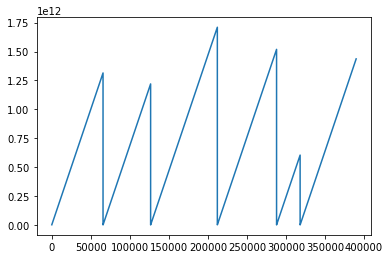

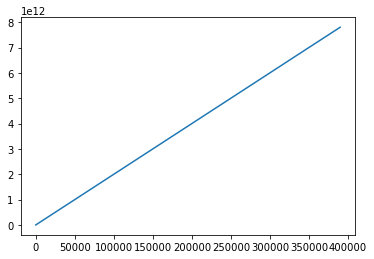

[350, 350, 350, 350, 350, 350]
[349, 699, 1049, 1399, 1749, 2099]


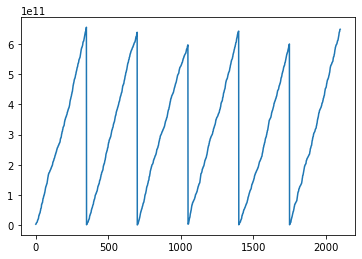

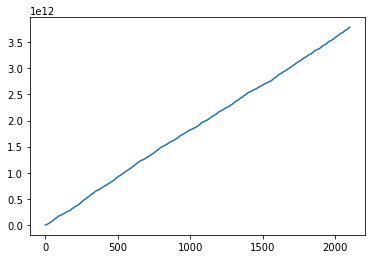

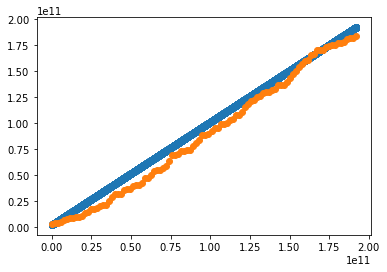

Original count 9500


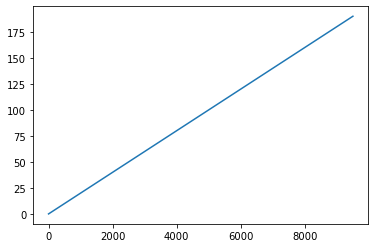

Representations: 101
[0.02 0.02 0.02 ... 0.02 0.02 0.02]
0.02
1.7872
Time: 9500
189980.0


In [16]:
# Two options for getting input data for the network. In all cases, position data is loaded/generated, then velocity derived in later cells
# 'spiral': original spiral trajectory
# 'rat': load one of the Sargolini group's datasets, from real rat foraging task data

if spiral_or_rat == 'spiral':
    
    number_of_turns = 300
    numT = number_of_turns * 1000 * np.pi
    print(numT/1000)
    dt = 20
    t = np.arange(0,sim_len,dt)*1.
    time = [i * 1. for i in t if i < sim_len]
    ts = np.arange(0,numT,numT/len(t))/1000.
    V = 30
    dr = 5
    ph = -np.sqrt(((V * (4*np.pi) * ts) / dr))
    ra =  np.sqrt(((V * dr * ts) / np.pi))

    pos_x = ra * np.cos(ph) 
    pos_y = ra * np.sin(ph)
    
elif spiral_or_rat == 'rat':
    
    # Roughly 92 20ms timesteps per representation
    
    N_data_samples = 9500
    N_representations = 102
    
    assert N_representations <= len(representations)
    
    from scipy.ndimage import median_filter, gaussian_filter
    
    # Load rat trajectory data from file
    
    data_folders = ['NRP_2021_testset1', 'NRP_2021_testset2', 'NRP_2021_testset3',
                    'NRP_2021_testset4', 'NRP_2021_testset5', 'NRP_2021_testset6']
    
    #data_folders = ['NRP_2021_testset1', 'NRP_2021_testset2']
    
    rat_dataset = [np.loadtxt('data/NRP_data/{}/raw_pose.csv'.format(folder), skiprows = 1, delimiter = ',') for folder in data_folders]
    
    # Find where each dataset ends. Timesteps also reset at these points.
    
    dataset_ends = [len(testset) for testset in rat_dataset]
    
    # Find where they will end in the combined dataset
    
    dataset_ends_cumulative = [sum(dataset_ends[:i]) - 1 for i in range(1,len(dataset_ends)+1)]
    
    # Apply the required fixes as per the README
    
    # rat_dataset[2][:,1] = rat_dataset[2][:,1] - 3 # Testset 3 needs adjusting -3m X and -6.1 Y
    # rat_dataset[2][:,2] = rat_dataset[2][:,2] - 6.1# Testset 3 needs adjusting -3m X and -6.1 Y
    # rat_dataset[3][:,2] = rat_dataset[3][:,2] - 6.1# Testset 4 needs adjusting -6.1 Y
    
    rat_dataset = np.vstack(rat_dataset)
    
    plt.plot(rat_dataset[:,0])
    
    plt.show()
    
    # Find the actual timestamps where each dataset end
    
    dataset_max_timestamps = rat_dataset[dataset_ends_cumulative, 0]
    
    # For each window of data, add on the previous maximum value; this should give a combined dataset with a monotonically increasing timestep
    
    dataset_cumulative_max_timestamps = [sum(dataset_max_timestamps[:i]) for i in range(1,len(dataset_max_timestamps)+1)]
    
    rat_dataset_timesteps_in_sequence = rat_dataset.copy()
    
    rat_dataset_timesteps_in_sequence[dataset_ends_cumulative[0]+1:, 0] = np.hstack([rat_dataset[i+1:j+1, 0] + m for i, j, m in zip(dataset_ends_cumulative[:-1], dataset_ends_cumulative[1:], dataset_cumulative_max_timestamps[:-1])])
    
    plt.plot(rat_dataset_timesteps_in_sequence[:,0])
    
    plt.show()
    
    assert np.all(rat_dataset_timesteps_in_sequence[1:, 0] > rat_dataset_timesteps_in_sequence[:-1, 0])
    
    # Now do the same for the representations
    
    rat_representation_timestamps = [np.load('data/NRP_data/{}/representation_matched_poses.npy'.format(folder))[:rep_count, 0] for folder, rep_count in zip(data_folders, representations_per_dataset)]
    
    # Find where each dataset ends. Timesteps also reset at these points.
    
    dataset_ends = [len(testset) for testset in rat_representation_timestamps]
    
    print(dataset_ends)
    
    # Find where they will end in the combined dataset
    
    dataset_ends_cumulative = [sum(dataset_ends[:i]) - 1 for i in range(1,len(dataset_ends)+1)]
    
    print(dataset_ends_cumulative)
    
    rat_representation_timestamps = np.hstack(rat_representation_timestamps)
    
    plt.plot(rat_representation_timestamps)
    
    plt.show()
    
    # Find the actual timestamps where each dataset end
    
    dataset_max_timestamps = rat_representation_timestamps[dataset_ends_cumulative]
    
    # For each window of data, add on the previous maximum value; this should give a combined dataset with a monotonically increasing timestep
    
    dataset_cumulative_max_timestamps = [sum(dataset_max_timestamps[:i]) for i in range(1,len(dataset_max_timestamps)+1)]
    
    rat_representations_timesteps_in_sequence = rat_representation_timestamps.copy()
    
    rat_representations_timesteps_in_sequence[dataset_ends_cumulative[0]+1:] = np.hstack([rat_representation_timestamps[i+1:j+1] + m for i, j, m in zip(dataset_ends_cumulative[:-1], dataset_ends_cumulative[1:], dataset_cumulative_max_timestamps[:-1])])
    
    plt.plot(rat_representations_timesteps_in_sequence)
    
    plt.show()
    
    assert np.all(rat_representations_timesteps_in_sequence[1:] > rat_representations_timesteps_in_sequence[:-1])
    
    rat_dataset_timesteps_in_sequence = rat_dataset_timesteps_in_sequence[:N_data_samples]
    rat_representations_timesteps_in_sequence = rat_representations_timesteps_in_sequence[:N_representations]
    
    # Now find where injections are required
    
    plt.scatter(np.linspace(0, max(rat_dataset_timesteps_in_sequence[:, 0]), num = len(rat_dataset_timesteps_in_sequence)), rat_dataset_timesteps_in_sequence[:, 0])
    plt.scatter(np.linspace(0, max(rat_dataset_timesteps_in_sequence[:, 0]), num = len(rat_representations_timesteps_in_sequence)), rat_representations_timesteps_in_sequence)
    plt.show()
    
    rat_injection_index = np.searchsorted(rat_dataset_timesteps_in_sequence[:, 0], rat_representations_timesteps_in_sequence)
    
    # Get rid of any redundant injections (only 2 at last check, so doesn't seem to be a systematic issue)
    
    rat_injection_index = rat_injection_index[np.nonzero(np.diff(rat_injection_index) > 0)]
    
    assert np.all(rat_injection_index[1:] > rat_injection_index[:-1])
    
    # Trim to desired interval
    
    # print(max(rat_dataset_timesteps_in_sequence[:,0]))
    # print(max(rat_representations_timesteps_in_sequence))
    # print(max(rat_injection_index))
    
    # rat_dataset_timesteps_in_sequence = rat_dataset_timesteps_in_sequence[:N_data_samples]
    # rat_representations_timesteps_in_sequence = rat_representations_timesteps_in_sequence[:N_representations]
#     rat_injection_index = rat_injection_index[rat_injection_index < int(max(rat_representations_timesteps_in_sequence))]
    
#     print(max(rat_dataset_timesteps_in_sequence[:,0]))
#     print(max(rat_representations_timesteps_in_sequence))
#     print(max(rat_injection_index))
    
    
    # Create variables for velocity calculation later
    
    pos_x = rat_dataset_timesteps_in_sequence[:,1]
    #pos_x = gaussian_filter(pos_x, sigma = smooth_sigma, mode = 'nearest')
    pos_y = rat_dataset_timesteps_in_sequence[:,2]
    #pos_y = gaussian_filter(pos_y, sigma = smooth_sigma, mode = 'nearest')
    
    theta = rat_dataset_timesteps_in_sequence[:,3]
    
    print(f"Original count {len(pos_x)}")
    #timestamps = np.arange(0, len(rat_dataset_timesteps_in_sequence)) / 50 # Hz
    timestamps = rat_dataset_timesteps_in_sequence[:, 0] - np.min(rat_dataset_timesteps_in_sequence[:, 0])
    
    timestamps = timestamps / 1000000000 # Get from nanoseconds to seconds

    plt.plot(timestamps)
    plt.show()
    
    # ^ Get this working on Friday
    
    injection_timestamps = timestamps[rat_injection_index]
    
    print(f"Representations: {len(injection_timestamps)}")
    
    print(np.diff(timestamps))
    print(np.mean(np.diff(timestamps)))
    print(np.mean(np.diff(injection_timestamps)))
    
    time = timestamps * 1000 # Get from seconds to milliseconds
    
    print(f"Time: {len(time)}")
    
    print(max(time))
    
else:
    
    raise ValueError

## Plot the loaded dataset

9500
102
(9499, 4)
(9499,)
(9499,)


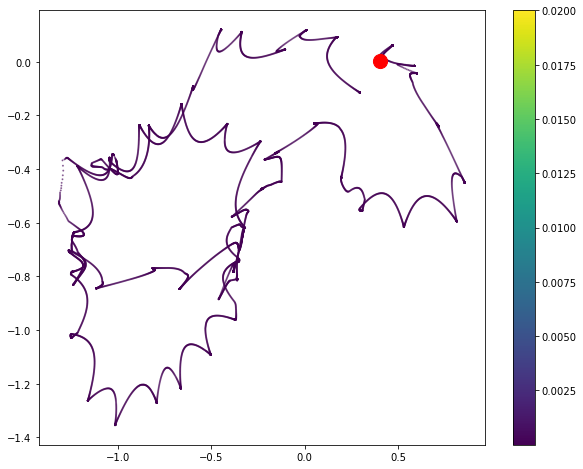

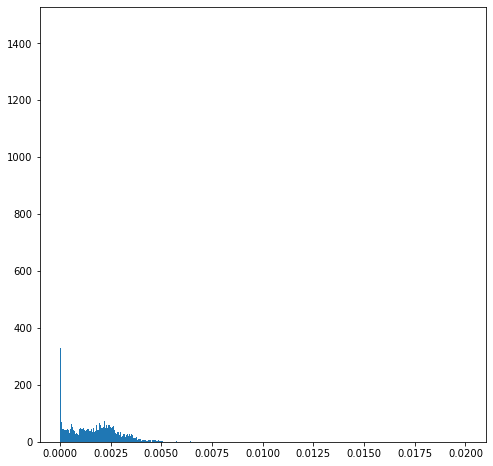

Final count 9500


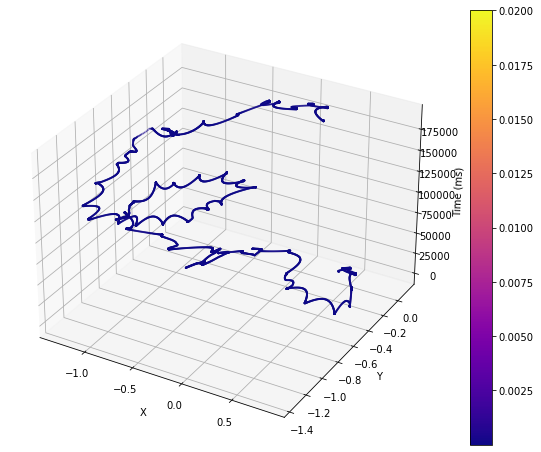

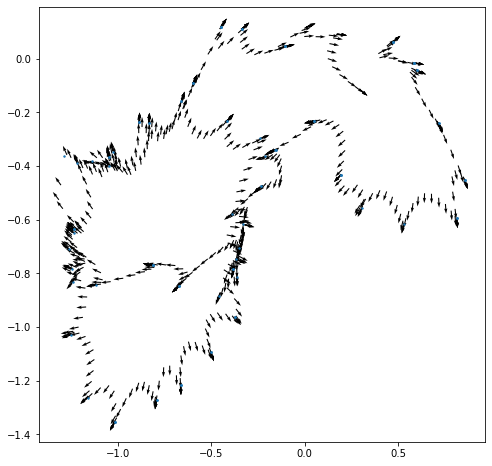

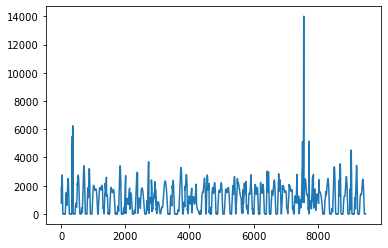

(array([17., 19., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 21., 23.]), array([   1,    1,   19,   36,   39,   15,    5,    4,    2, 9253,    2,
          3,   21,    7,   89,    1,    1]))
9500
9499


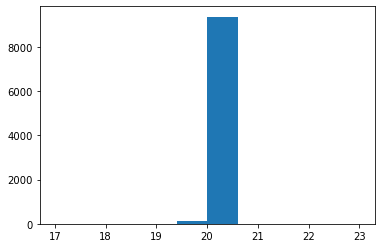

In [17]:
print(len(rat_dataset_timesteps_in_sequence))
print(len(rat_representations_timesteps_in_sequence))

fig, ax = plt.subplots(1, 1, figsize = (10,8))

from matplotlib.colors import Normalize as colour_norm
from matplotlib import cm

velocity_magnitude = np.sqrt(np.diff(pos_x) ** 2 + np.diff(pos_y) ** 2)
colour_index = velocity_magnitude#np.linspace(0, 1, num = 120)
velocity_colours = cm.get_cmap('viridis')(colour_index)

print(velocity_colours.shape)
print(pos_x[:-1].shape)
print(pos_y[:-1].shape)

ax.scatter(pos_x[:-1],pos_y[:-1], c = velocity_colours, s = 1, alpha = 0.5)
ax.scatter(pos_x[0],pos_y[0], c = 'red', s = 200, alpha = 1)

norm = colour_norm(vmin=min(velocity_magnitude), vmax=max(velocity_magnitude))

norm_colours = norm(velocity_colours)

velocity_colours = cm.ScalarMappable(norm = norm, cmap = 'viridis')

fig.colorbar(velocity_colours, ax = ax)

plt.show()

fig, ax = plt.subplots(1, 1, figsize = (8,8))

ax.hist(velocity_magnitude, bins = 1000)

plt.show()

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1,1,1, projection = '3d')

velocity_colours = cm.get_cmap('plasma')(colour_index)

ax.scatter(pos_x[:-1], pos_y[:-1], time[:-1], c = velocity_colours, s = 1, alpha = 0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Time (ms)")

velocity_colours = cm.ScalarMappable(norm = norm, cmap = 'plasma')

fig.colorbar(velocity_colours, ax = ax)

fig, ax = plt.subplots(1, 1, figsize = (8,8))

print(f"Final count {len(pos_x)}")

ax.quiver(pos_x[::15], pos_y[::15], np.cos(theta)[::15], np.sin(theta)[::15], angles = 'xy', pivot = 'tail')

ax.scatter(pos_x[rat_injection_index], pos_y[rat_injection_index], s = 2)

plt.show()

vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)

vel_x,vel_y = vel_x*I_vel, vel_y*I_vel

velocity_magnitude = np.sqrt(vel_x ** 2 + vel_y ** 2)

plt.plot(velocity_magnitude)

plt.show()

update_time = np.diff(time)

plt.hist(update_time)

print(np.unique(update_time, return_counts = True))

#time = np.arange(0, max(time)+20, step = 20).astype('float')

print(len(time))
print(len(vel_x))

### Calculate velocity

9499
9499
2000.022742710213
2000.0273067101243
2000.013229432671
2000.0297952273054
2000.0155114326267
2000.0345379877108


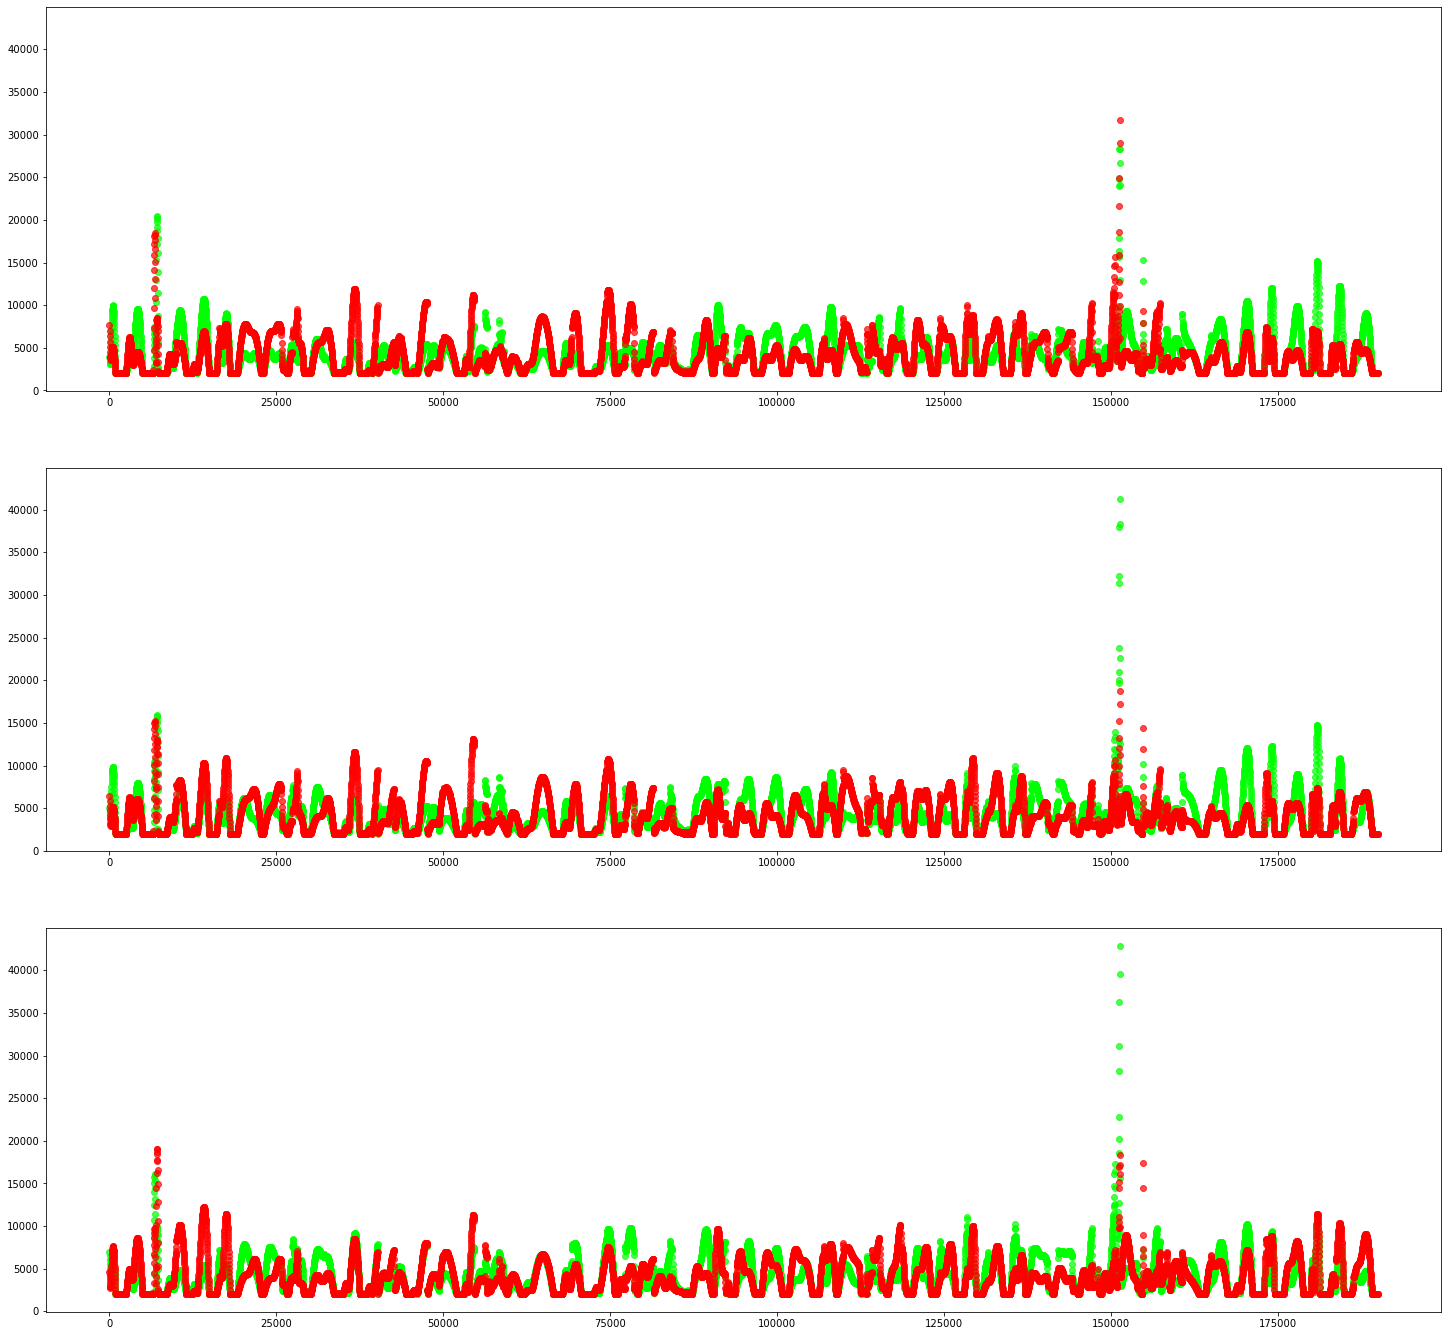

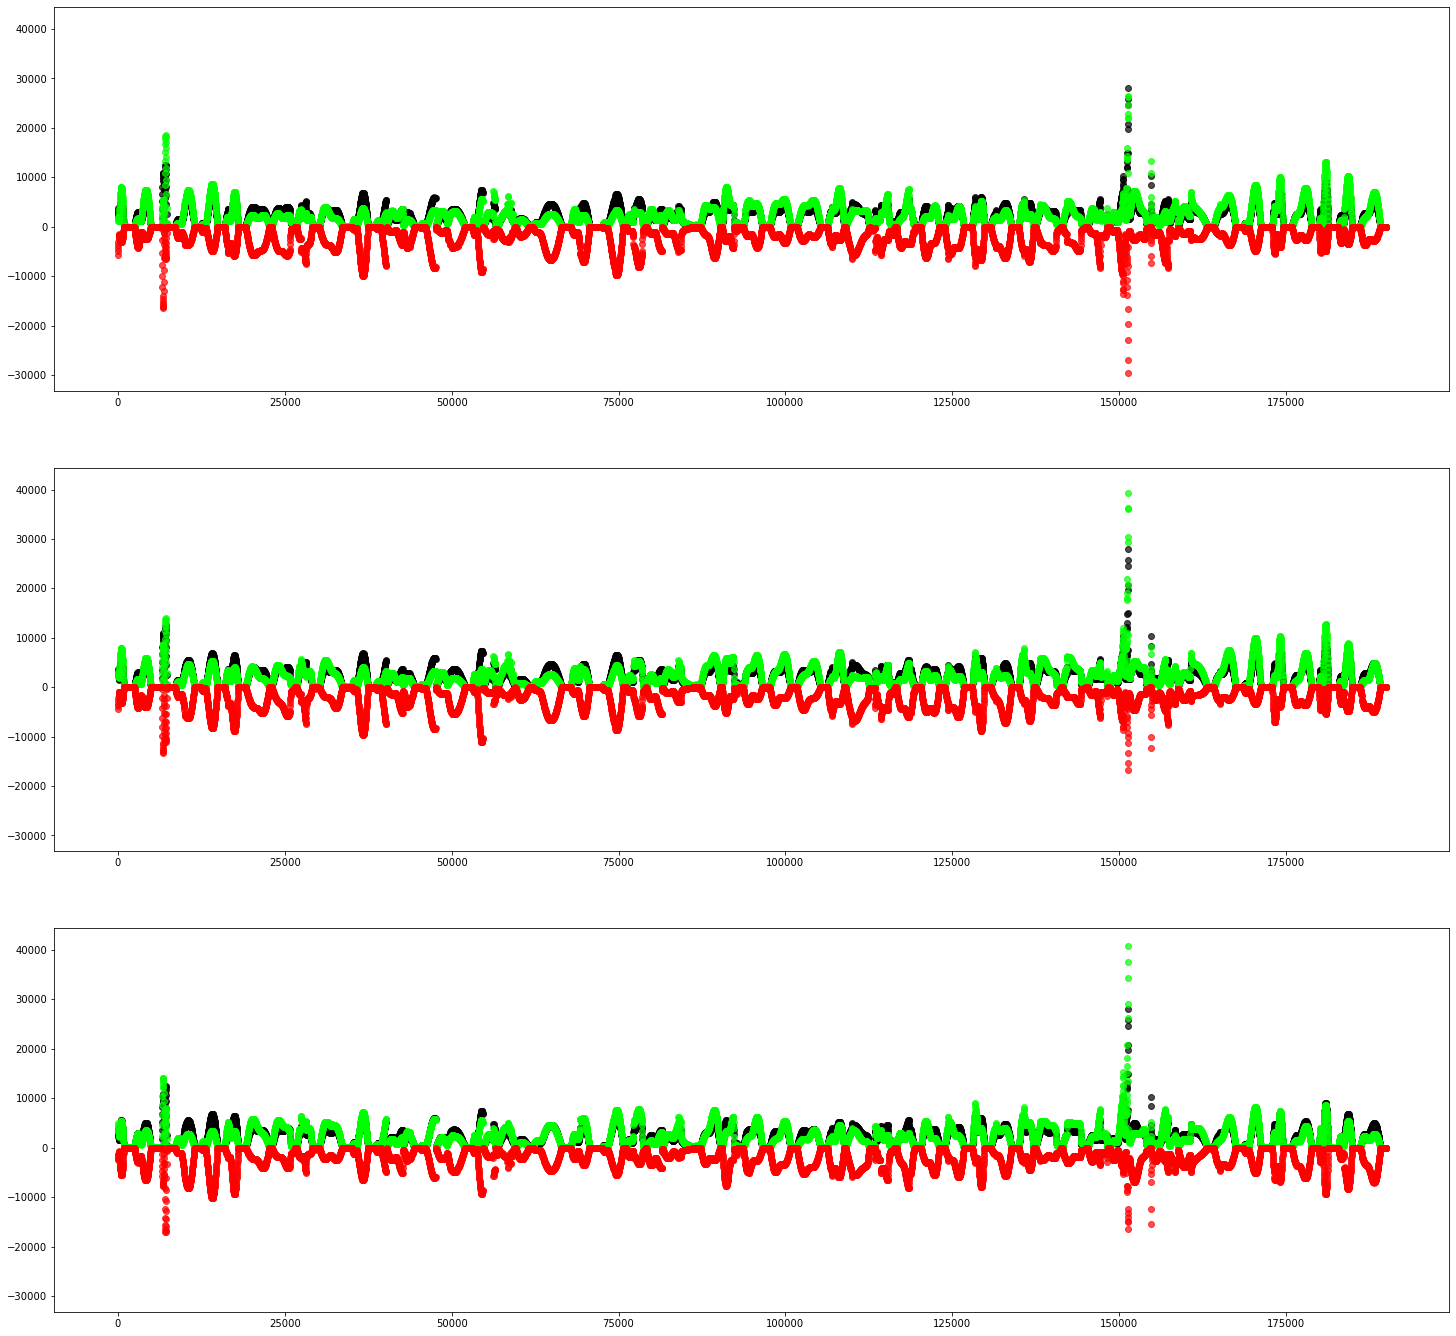

In [18]:
# Calculate velocity to convert to step current
# As with head direction network, small values are boosted, but values that were 0 or less are set back to 0

vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)

vel_x,vel_y = vel_x*I_vel, vel_y*I_vel

# Now we split this across the rings according to their direction of travel

# Axes are:
# Y, as usual
# X_plus_60 (60 degree offset from Y around origin, diagonal bottom-right to upper-left)
# X_plus_120 (120 degree offset from Y around origin, diagonal bottom-left to upper-right)

velocity_magnitude = np.sqrt(vel_x ** 2 + vel_y ** 2)

#if velocity_threshold:

#    velocity_magnitude = velocity_magnitude + minimum_velocity

#    velocity_magnitude[velocity_magnitude < minimum_velocity] = 0.

velocity_angle = np.arctan2(vel_y, vel_x)

# Calculate overall components for use in later analysis

Y_input_total = velocity_magnitude * np.cos(velocity_angle)

Y_plus_60_offset = np.radians(60)
Y_plus_120_offset = np.radians(120)

Y_plus_60_input_total = velocity_magnitude * np.cos(velocity_angle - Y_plus_60_offset)
Y_plus_120_input_total = velocity_magnitude * np.cos(velocity_angle - Y_plus_120_offset)

# Now split into positive and negative to feed to left and right conjunctive cells respectively

velocity_component = np.cos(velocity_angle)

positive_component = velocity_component.copy()
negative_component = velocity_component.copy()

positive_component[positive_component < 0] = 0.
negative_component[negative_component > 0] = 0.

Y_input_l = velocity_magnitude * positive_component
Y_input_r = velocity_magnitude * negative_component

Y_input_r = -Y_input_r

Y_input_l_compliment = velocity_magnitude - Y_input_l
Y_input_r_compliment = velocity_magnitude - Y_input_r

Y_input_l = velocity_magnitude + Y_input_l + Y_input_r_compliment + minimum_input
Y_input_r = velocity_magnitude + Y_input_r + Y_input_l_compliment + minimum_input
    
# Connect y input to conjunctive layers

print(len(time[1:]))
print(len(Y_input_l))

y_l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(y_l_input,{'amplitude_times': time[1:],'amplitude_values': Y_input_l})

y_r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(y_r_input,{'amplitude_times': time[1:],'amplitude_values': Y_input_r})

sim.Connect(y_l_input,l[0],'all_to_all')
sim.Connect(y_r_input,r[0],'all_to_all')


velocity_component_60 = np.cos(velocity_angle - Y_plus_60_offset)

positive_component_60 = velocity_component_60.copy()
negative_component_60 = velocity_component_60.copy()

positive_component_60[positive_component_60 < 0] = 0.
negative_component_60[negative_component_60 > 0] = 0.

Y_plus_60_input_l = velocity_magnitude * positive_component_60 # np.cos(positive_angle - Y_plus_60_offset)
Y_plus_60_input_r = velocity_magnitude * negative_component_60 # np.cos(negative_angle - Y_plus_60_offset)

Y_plus_60_input_r = -Y_plus_60_input_r

Y_plus_60_input_l_compliment = velocity_magnitude - Y_plus_60_input_l
Y_plus_60_input_r_compliment = velocity_magnitude - Y_plus_60_input_r

Y_plus_60_input_l = velocity_magnitude + Y_plus_60_input_l + Y_plus_60_input_r_compliment + minimum_input
Y_plus_60_input_r = velocity_magnitude + Y_plus_60_input_r + Y_plus_60_input_l_compliment + minimum_input


velocity_component_120 = np.cos(velocity_angle - Y_plus_120_offset)

positive_component_120 = velocity_component_120.copy()
negative_component_120 = velocity_component_120.copy()

positive_component_120[positive_component_120 < 0] = 0.
negative_component_120[negative_component_120 > 0] = 0.

Y_plus_120_input_l = velocity_magnitude * positive_component_120 # np.cos(positive_angle - Y_plus_120_offset)
Y_plus_120_input_r = velocity_magnitude * negative_component_120 # np.cos(negative_angle - Y_plus_120_offset)

Y_plus_120_input_r = -Y_plus_120_input_r
                      
Y_plus_120_input_l_compliment = velocity_magnitude - Y_plus_120_input_l
Y_plus_120_input_r_compliment = velocity_magnitude - Y_plus_120_input_r

Y_plus_120_input_l = velocity_magnitude + Y_plus_120_input_l + Y_plus_120_input_r_compliment + minimum_input
Y_plus_120_input_r = velocity_magnitude + Y_plus_120_input_r + Y_plus_120_input_l_compliment + minimum_input

    
# Connect y_plus_60 input to conjunctive layers

Y_plus_60_l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(Y_plus_60_l_input,{'amplitude_times': time[1:],'amplitude_values': Y_plus_60_input_l})
Y_plus_60_r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(Y_plus_60_r_input,{'amplitude_times': time[1:],'amplitude_values': Y_plus_60_input_r})

sim.Connect(Y_plus_60_l_input,l[1],'all_to_all')
sim.Connect(Y_plus_60_r_input,r[1],'all_to_all')

# Connect y_plus_120 input to conjunctive layers

Y_plus_120_l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(Y_plus_120_l_input,{'amplitude_times': time[1:],'amplitude_values': Y_plus_120_input_l})
Y_plus_120_r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(Y_plus_120_r_input,{'amplitude_times': time[1:],'amplitude_values': Y_plus_120_input_r})

sim.Connect(Y_plus_120_l_input,l[2],'all_to_all')
sim.Connect(Y_plus_120_r_input,r[2],'all_to_all')

print(min(Y_input_l))
print(min(Y_input_r))
print(min(Y_plus_60_input_l))
print(min(Y_plus_60_input_r))
print(min(Y_plus_120_input_l))
print(min(Y_plus_120_input_r))


# Plot velocity components for sanity's sake

fig, axes = plt.subplots(3,1, figsize=(25,24), sharey = True)

axes[0].scatter(time[:-1], Y_input_l, alpha = 0.7, c = 'lime')
axes[0].scatter(time[:-1], Y_input_r, alpha = 0.7, c = 'red')

axes[1].scatter(time[:-1], Y_plus_60_input_l, alpha = 0.7, c = 'lime')
axes[1].scatter(time[:-1], Y_plus_60_input_r, alpha = 0.7, c = 'red')

axes[2].scatter(time[:-1], Y_plus_120_input_l, alpha = 0.7, c = 'lime')
axes[2].scatter(time[:-1], Y_plus_120_input_r, alpha = 0.7, c = 'red')

fig, axes = plt.subplots(3,1, figsize=(25,24), sharey = True)

axes[0].scatter(time[:-1], velocity_magnitude * 2, alpha = 0.7, c = 'black')
axes[0].scatter(time[:-1], Y_input_l-minimum_input, alpha = 0.7, c = 'lime')
axes[0].scatter(time[:-1], -(Y_input_r-minimum_input), alpha = 0.7, c = 'red')

axes[1].scatter(time[:-1], velocity_magnitude * 2, alpha = 0.7, c = 'black')
axes[1].scatter(time[:-1], Y_plus_60_input_l-minimum_input, alpha = 0.7, c = 'lime')
axes[1].scatter(time[:-1], -(Y_plus_60_input_r-minimum_input), alpha = 0.7, c = 'red')

axes[2].scatter(time[:-1], velocity_magnitude * 2, alpha = 0.7, c = 'black')
axes[2].scatter(time[:-1], Y_plus_120_input_l-minimum_input, alpha = 0.7, c = 'lime')
axes[2].scatter(time[:-1], -(Y_plus_120_input_r-minimum_input), alpha = 0.7, c = 'red')

### Bump-forming current generator

In [19]:
# Inject current for a given duration to start the bump off

bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[0][I_init_pos]])
sim.Connect(bump_init,[exc[1][I_init_pos]])
sim.Connect(bump_init,[exc[2][I_init_pos]])

## Run simulation in tandem with representation corrections

In [20]:
# Get the memory set up and data loaded

from scipy.stats import pearsonr

sense_memories = [] # Save representations from PredNet
location_memories = [] # Save ring coordinates from NEST

recall_threshold = 0.8

In [21]:
print(pa_to_pyramidal_connections)

     Target Cell Index  Target Pyramidal Cell  Ring 1 Index  Ring 2 Index  \
0                  0.0                 1477.0           0.0           0.0   
1                  1.0                 1478.0           0.0           0.0   
2                  2.0                 1479.0           0.0           0.0   
3                  3.0                 1480.0           0.0           0.0   
4                  4.0                 1481.0           0.0           0.0   
..                 ...                    ...           ...           ...   
211              211.0                 1688.0           5.0           5.0   
212              212.0                 1689.0           5.0           5.0   
213              213.0                 1690.0           5.0           5.0   
214              214.0                 1691.0           5.0           5.0   
215              215.0                 1692.0           5.0           5.0   

     Ring 3 Index  Ring 1 PA Cell  Ring 2 PA Cell  Ring 3 PA Cell  
0      

In [22]:
print(input_device_to_ring_cells_connections)

     Source Device Index  Source Device  Ring 1 Virtual RP  Ring 2 Virtual RP  \
0                    0.0         1693.0                0.0                0.0   
1                    1.0         1694.0                0.0                0.0   
2                    2.0         1695.0                0.0                0.0   
3                    3.0         1696.0                0.0                0.0   
4                    4.0         1697.0                0.0                0.0   
..                   ...            ...                ...                ...   
211                211.0         1904.0                5.0                5.0   
212                212.0         1905.0                5.0                5.0   
213                213.0         1906.0                5.0                5.0   
214                214.0         1907.0                5.0                5.0   
215                215.0         1908.0                5.0                5.0   

     Ring 3 Virtual RP  Rin

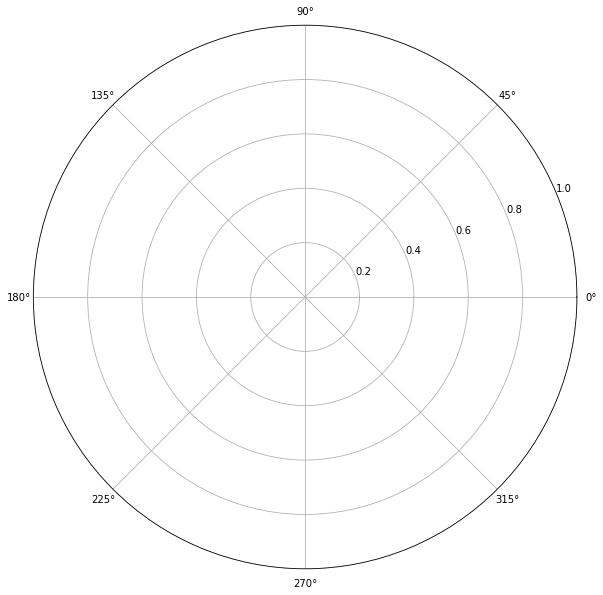

In [23]:
# Run simulation in steps, pausing only when representations are available

timestamps = timestamps - np.min(timestamps)

representation_timestamps = injection_timestamps - np.min(timestamps)

representation_times = representation_timestamps * 1000

time_deltas = np.diff(time).astype(int)

representation_time_deltas = np.diff(representation_times).astype(int)

start_delay = 100

no_spike_timeout = 5

recalls = 0
new_memories = 0

sim.set_verbosity(18)

correction_timesteps = 5
correction_current = 500.

exc_state_history_per_rep = np.zeros(shape = (len(representation_time_deltas), rings, N_ex))

injection_or_not = np.zeros(shape = (len(representation_time_deltas)))

if simulate_or_load == 'simulate':    
    
    with sim.RunManager():
    
        for time_delta, t, tick, representation in zip(representation_time_deltas, representation_times, range(len(representation_times)), representations):
            
            #print(f"Time delta {time_delta}")
            
            sim.Run(time_delta)
            
            #print(f"Finished timestep {tick}")
            
            ring1_exc, ring1_spikes_exc = np.unique(sim.GetStatus(exc_spikes[0])[0]['events']['senders'], return_counts = True)
            ring2_exc, ring2_spikes_exc = np.unique(sim.GetStatus(exc_spikes[1])[0]['events']['senders'], return_counts = True)
            ring3_exc, ring3_spikes_exc = np.unique(sim.GetStatus(exc_spikes[2])[0]['events']['senders'], return_counts = True)
            
            ring1_most_active_exc_index = np.argmax(ring1_spikes_exc) if ring1_spikes_exc.size > 0 else None
            ring2_most_active_exc_index = np.argmax(ring2_spikes_exc) if ring2_spikes_exc.size > 0 else None
            ring3_most_active_exc_index = np.argmax(ring3_spikes_exc) if ring3_spikes_exc.size > 0 else None
            
            current_exc_state = (ring1_most_active_exc_index, ring2_most_active_exc_index, ring3_most_active_exc_index)
            
            if np.all(current_exc_state):
            
                exc_state_history_per_rep[tick, 0, ring1_exc-min(ring1_exc)] = ring1_spikes_exc
                exc_state_history_per_rep[tick, 1, ring2_exc-min(ring2_exc)] = ring2_spikes_exc
                exc_state_history_per_rep[tick, 2, ring3_exc-min(ring3_exc)] = ring3_spikes_exc
            
            ring1_rp, ring1_spikes_rp = np.unique(sim.GetStatus(pa_spikes[0])[0]['events']['senders'], return_counts = True)
            ring2_rp, ring2_spikes_rp = np.unique(sim.GetStatus(pa_spikes[1])[0]['events']['senders'], return_counts = True)
            ring3_rp, ring3_spikes_rp = np.unique(sim.GetStatus(pa_spikes[2])[0]['events']['senders'], return_counts = True)
            
            ring1_most_active_rp_index = np.argmax(ring1_spikes_rp) if ring1_spikes_rp.size > 0 else None
            ring2_most_active_rp_index = np.argmax(ring2_spikes_rp) if ring2_spikes_rp.size > 0 else None
            ring3_most_active_rp_index = np.argmax(ring3_spikes_rp) if ring3_spikes_rp.size > 0 else None
            
            ring1_most_active_rp = ring1_rp[ring1_most_active_rp_index] if ring1_most_active_rp_index is not None else None
            ring2_most_active_rp = ring2_rp[ring2_most_active_rp_index] if ring2_most_active_rp_index is not None else None
            ring3_most_active_rp = ring3_rp[ring3_most_active_rp_index] if ring3_most_active_rp_index is not None else None
            
            current_rp_state = (ring1_most_active_rp_index, ring2_most_active_rp_index, ring3_most_active_rp_index)
            
            if np.all(current_rp_state):
            
                recalled_ring_state_r1, recalled_ring_state_r2, recalled_ring_state_r3 = -1, -1, -1
            
                if len(sense_memories) == 0:

                    sense_memories.append(representation)

                if len(location_memories) == 0:

                    location_memories.append(current_rp_state)

                pearson_coorelation = np.empty(shape = (len(sense_memories)))

                for sm, sense_memory in enumerate(sense_memories):

                    pearson_coorelation[sm] = 1 - pearsonr(representation, sense_memory)[0]

                best_match_index = np.argmax(pearson_coorelation) if pearson_coorelation.size > 0 else None

                best_match_element = sense_memories[best_match_index] if best_match_index is not None else None

                best_match_value = pearson_coorelation[best_match_index] if best_match_index is not None else None
                

                if best_match_value is None and timestamp > start_delay:

                    no_spike_timeout -= 1
                    

                elif best_match_value >= recall_threshold:

                    recalls += 1
                    
                    recalled_ring_state_r1, recalled_ring_state_r2, recalled_ring_state_r3 = location_memories[best_match_index]
                    
                    input_device = int(input_device_to_ring_cells_connections.query("`Ring 1 Virtual RP` == @recalled_ring_state_r1 and `Ring 2 Virtual RP` == @recalled_ring_state_r2 and `Ring 3 Virtual RP` == @recalled_ring_state_r3")['Source Device'].values[0])

                    sim.SetStatus([input_device], {'amplitude_times': time[tick:tick+correction_timesteps],'amplitude_values': np.tile(correction_current, correction_timesteps)})
                
                    injection_or_not[tick] = 1
                            
                elif np.abs(pearson_coorelation[best_match_index]) < recall_threshold:

                    new_memories += 1

                    sense_memories.append(representation)

                    location_memories.append(current_rp_state)

                
                if no_spike_timeout <= 0:

                    print(f"No spikes have been recorded for {no_spike_timeout} input cycles, stopping...")

                    break
                
                print(f"Experience: {tick+1}/{len(representation_time_deltas)}; Sim Time: {int(t)}; Ring State: {current_exc_state}; RP State: {current_rp_state}; Injection Sites: {(recalled_ring_state_r1, recalled_ring_state_r2, recalled_ring_state_r3)}; Memories Stored: {new_memories}; Recall events: {recalls}", end = '\r')

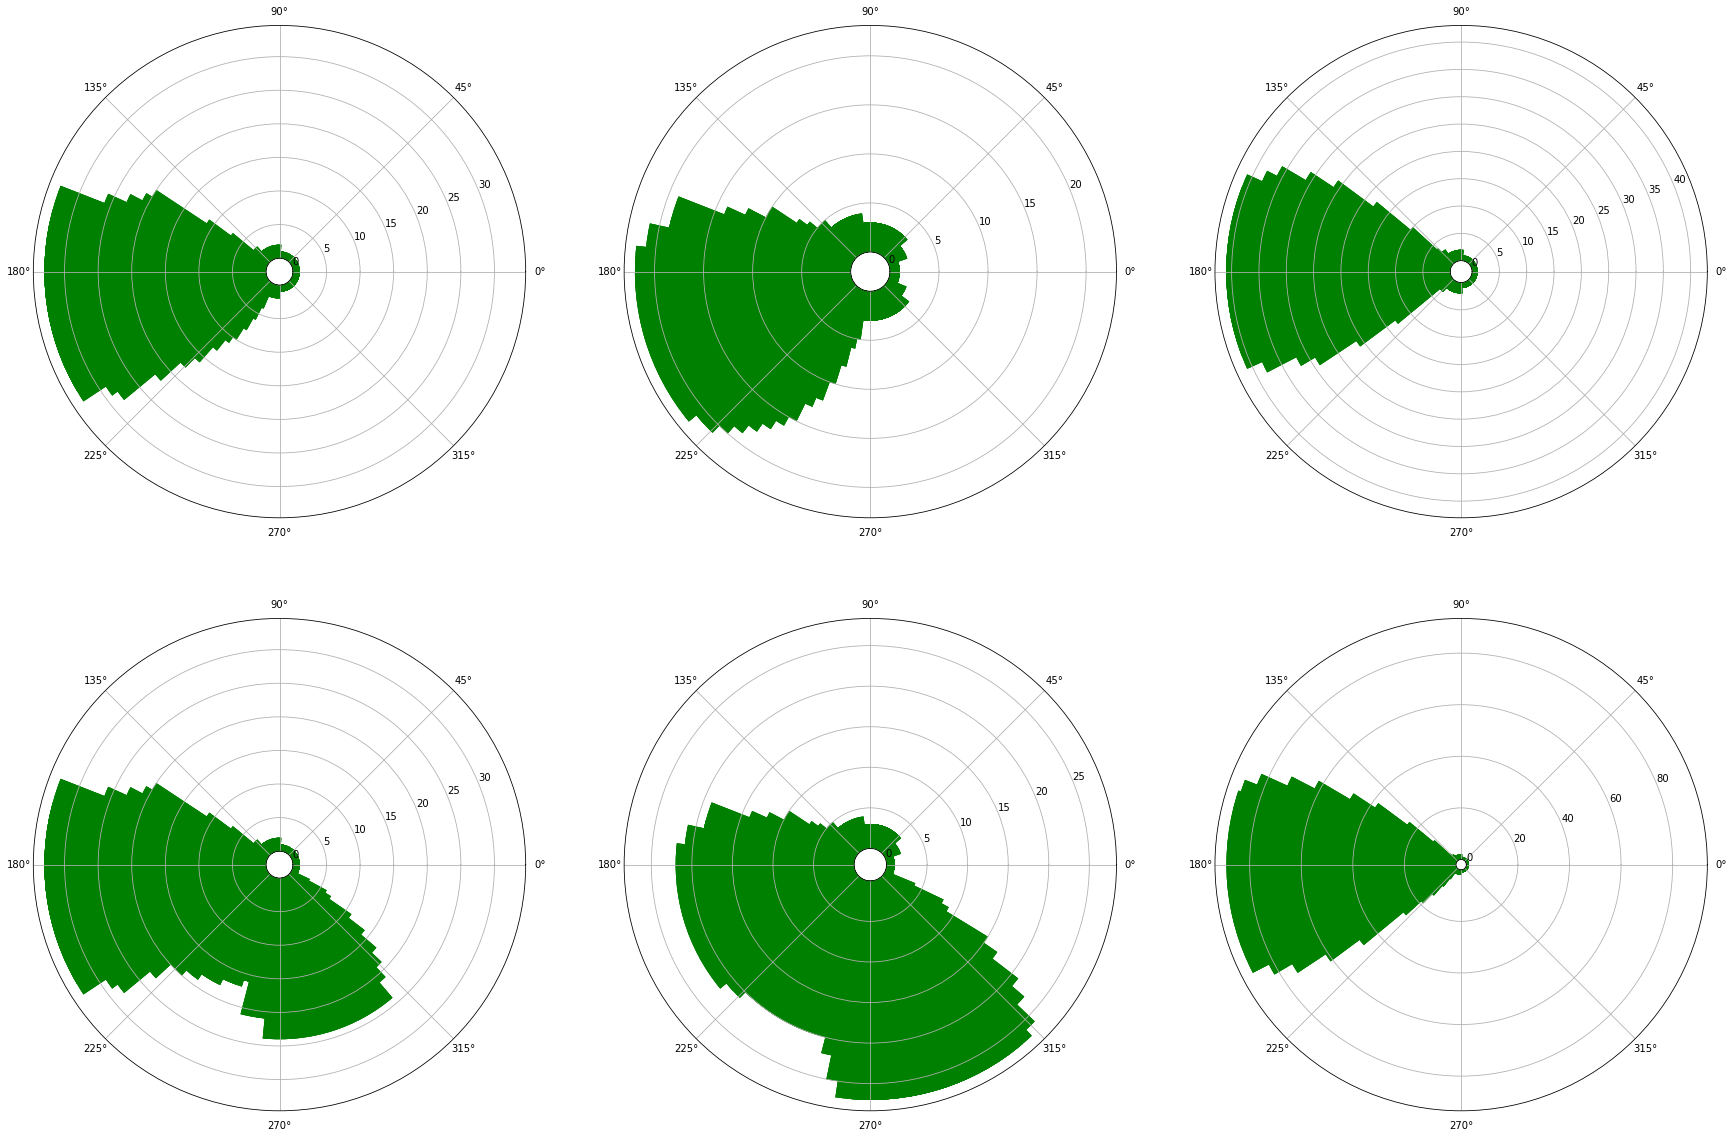

In [31]:
# Static frames of ring activity during injection

cell_indices_for_plotting = np.linspace(0, 2*np.pi, num = N_ex)

fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize = (30, 20))



for r, row in enumerate(ax):
    
    for c, column in enumerate(row):
        
        ax[r, c].set_rorigin(-2)
        
        if not injection_or_not[r]:
        
            ax[r, c].bar(cell_indices_for_plotting, exc_state_history_per_rep[r, c, :], color = 'green')
            ax[r, c].bar(cell_indices_for_plotting, exc_state_history_per_rep[r, c, :], color = 'green')
            ax[r, c].bar(cell_indices_for_plotting, exc_state_history_per_rep[r, c, :], color = 'green')
        
        elif injection_or_not[r]:
            
            ax[r, c].bar(cell_indices_for_plotting, exc_state_history_per_rep[r, c, :], color = 'red')
            ax[r, c].bar(cell_indices_for_plotting, exc_state_history_per_rep[r, c, :], color = 'red')
            ax[r, c].bar(cell_indices_for_plotting, exc_state_history_per_rep[r, c, :], color = 'red')

plt.show()

In [25]:
def cart2ring(x, y, offset):

    if not isinstance(x, np.ndarray):

        x = np.array(x)

    if not isinstance(y, np.ndarray):

        y = np.array(y)

    assert x.size == y.size
    assert x.size > 0

    if x.size == 1:

        projection_r1 = np.dot(np.array([x, y]), np.array([x, -x / np.tan(np.radians(offset))])) / np.linalg.norm(np.array([x, -x / np.tan(np.radians(offset))]))
        projection_r2 = np.dot(np.array([x, y]), np.array([x, -x / np.tan(np.radians(60 + offset))])) / np.linalg.norm(np.array([x, -x / np.tan(np.radians(60 + offset))]))
        projection_r3 = np.dot(np.array([x, y]), np.array([x, x / np.tan(np.radians(60 - offset))])) / np.linalg.norm(np.array([x, x / np.tan(np.radians(60 - offset))]))

    elif x.size > 1:

        projection_r1 = np.array([np.dot(np.array([i, j]), np.array([i, -i / np.tan(np.radians(offset))])) / np.linalg.norm(np.array([i, -i / np.tan(np.radians(offset))])) for i, j in zip(x, y)])
        projection_r2 = np.array([np.dot(np.array([i, j]), np.array([i, -i / np.tan(np.radians(60 + offset))])) / np.linalg.norm(np.array([i, -i / np.tan(np.radians(60 + offset))])) for i, j in zip(x, y)])
        projection_r3 = np.array([np.dot(np.array([i, j]), np.array([i, i / np.tan(np.radians(60 - offset))])) / np.linalg.norm(np.array([i, i / np.tan(np.radians(60 - offset))])) for i, j in zip(x, y)])
        

    else:

        raise NotImplementedError
    
    offset = offset % 360

    if offset >= 0 and offset < 60:

        ring1 = -np.sign(x) * projection_r1
        ring2 = -np.sign(x) * projection_r2
        ring3 = -np.sign(x) * projection_r3

    elif offset >= 60 and offset < 120:

        ring1 = -np.sign(x) * projection_r1
        ring2 = -np.sign(x) * projection_r2
        ring3 = np.sign(x) * projection_r3

    elif offset >= 120 and offset < 180:

        ring1 = -np.sign(x) * projection_r1
        ring2 = np.sign(x) * projection_r2
        ring3 = np.sign(x) * projection_r3

    elif offset >= 180 and offset < 240:

        ring1 = np.sign(x) * projection_r1
        ring2 = np.sign(x) * projection_r2
        ring3 = np.sign(x) * projection_r3

    elif offset >= 240 and offset < 300:

        ring1 = np.sign(x) * projection_r1
        ring2 = np.sign(x) * projection_r2
        ring3 = -np.sign(x) * projection_r3

    elif offset >= 300 and offset < 360:

        ring1 = np.sign(x) * projection_r1
        ring2 = -np.sign(x) * projection_r2
        ring3 = -np.sign(x) * projection_r3

    return np.array([ring1, ring2, ring3]).T

def ring2cart(ring1, ring2, ring3, offset):

    if not isinstance(ring1, np.ndarray):

        ring1 = np.array(ring1)

    if not isinstance(ring2, np.ndarray):

        ring2 = np.array(ring2)

    if not isinstance(ring3, np.ndarray):

        ring3 = np.array(ring3)

    assert ring1.size > 0    
    
    danger_values_r1 = [x for x in range(0, 360, 90)] # r1 will align with x or y at these offset values
    danger_values_r2 = [x for x in range(30, 360, 90)] # r2 will align with x or y at these offset values
    danger_values_r3 = [x for x in range(60, 360, 90)] # r3 will align with x or y at these offset values

    ### New method: Use intersection of normals to find the corresponding (x,y) 
    
    # Draw ring axes that span the length of the arena in question
    # The maximum extent of x and y are equal to the longest ring
    # The largest ratio of ring:cartesian values are if a ring axis is aligned exactly to x or y
    # Therefore, no point in ring space can be outside the corresponding bounds in cartesian space

    if offset not in danger_values_r1 and offset not in danger_values_r2 and offset not in danger_values_r3:
    
        max_x = np.max([ring1, ring2, ring3], axis = 0) / np.cos(np.radians(np.max([offset, offset + 60, offset + 120])))
        min_x = -max_x
        
        ring1_y = ring1 / np.cos(np.radians(offset))
        ring2_y = ring2 / np.cos(np.radians(60 + offset))
        ring3_y = -ring3 / np.cos(np.radians(60 - offset))

        y_r1_n_start    =  -max_x * np.tan(np.radians(offset)) + ring1_y
        y_r1_n_end      =  -min_x * np.tan(np.radians(offset)) + ring1_y

        y_r2_n_start    =  -max_x * np.tan(np.radians(60 + offset)) + ring2_y
        y_r2_n_end      =  -min_x * np.tan(np.radians(60 + offset)) + ring2_y

        y_r3_n_start    =  max_x * np.tan(np.radians(60 - offset)) + ring3_y
        y_r3_n_end      =  min_x * np.tan(np.radians(60 - offset)) + ring3_y
        
        # Get start and end points of ring axes
        
        start_r1_n = np.array([min_x, y_r1_n_start])
        start_r2_n = np.array([min_x, y_r2_n_start])
        start_r3_n = np.array([min_x, y_r3_n_start])

        end_r1_n = np.array([max_x, y_r1_n_end])
        end_r2_n = np.array([max_x, y_r2_n_end])
        end_r3_n = np.array([max_x, y_r3_n_end])
        
        x_values = np.empty(shape = (ring1.size, 3))
        y_values = np.empty(shape = (ring1.size, 3))
        
        # Calculate where each pair intersects

        x1,y1 = start_r1_n
        x2,y2 = end_r1_n
        x3,y3 = start_r2_n
        x4,y4 = end_r2_n

        denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
        ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
        ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
        x = x3 + ua * (x4-x3)
        y = y3 + ua * (y4-y3)

        x_values[:, 0] = x
        y_values[:, 0] = y

        x1,y1 = start_r2_n
        x2,y2 = end_r2_n
        x3,y3 = start_r3_n
        x4,y4 = end_r3_n

        denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
        ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
        ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
        x = x3 + ua * (x4-x3)
        y = y3 + ua * (y4-y3)

        x_values[:, 1] = x
        y_values[:, 1] = y

        x1,y1 = start_r1_n
        x2,y2 = end_r1_n
        x3,y3 = start_r3_n
        x4,y4 = end_r3_n

        denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
        ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
        ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
        x = x3 + ua * (x4-x3)
        y = y3 + ua * (y4-y3)

        x_values[:, 2] = x
        y_values[:, 2] = y
    
    elif offset in danger_values_r1:
        
        max_x = np.max([ring2, ring3], axis = 0) / np.cos(np.radians(np.max([offset, offset + 60, offset + 120])))
        min_x = -max_x
        
        ring2_y = ring2 / np.cos(np.radians(60 + offset))
        ring3_y = -ring3 / np.cos(np.radians(60 - offset))

        y_r2_n_start    =  -max_x * np.tan(np.radians(60 + offset)) + ring2_y
        y_r2_n_end      =  -min_x * np.tan(np.radians(60 + offset)) + ring2_y

        y_r3_n_start    =  max_x * np.tan(np.radians(60 - offset)) + ring3_y
        y_r3_n_end      =  min_x * np.tan(np.radians(60 - offset)) + ring3_y
        
        # Get start and end points of ring axes
        
        start_r2_n = np.array([min_x, y_r2_n_start])
        start_r3_n = np.array([min_x, y_r3_n_start])

        end_r2_n = np.array([max_x, y_r2_n_end])
        end_r3_n = np.array([max_x, y_r3_n_end])
        
        x_values = np.empty(shape = (ring1.size, 1))
        y_values = np.empty(shape = (ring1.size, 1))
        
        # Calculate where each pair intersects

        x1,y1 = start_r2_n
        x2,y2 = end_r2_n
        x3,y3 = start_r3_n
        x4,y4 = end_r3_n

        denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
        ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
        ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
        x = x3 + ua * (x4-x3)
        y = y3 + ua * (y4-y3)

        x_values[:, 0] = x
        y_values[:, 0] = y
        
    elif offset in danger_values_r2:
        
        max_x = np.max([ring1, ring3], axis = 0) / np.cos(np.radians(np.max([offset, offset + 60, offset + 120])))
        min_x = -max_x
        
        ring1_y = ring1 / np.cos(np.radians(offset))
        ring3_y = -ring3 / np.cos(np.radians(60 - offset))

        y_r1_n_start    =  -max_x * np.tan(np.radians(offset)) + ring1_y
        y_r1_n_end      =  -min_x * np.tan(np.radians(offset)) + ring1_y

        y_r3_n_start    =  max_x * np.tan(np.radians(60 - offset)) + ring3_y
        y_r3_n_end      =  min_x * np.tan(np.radians(60 - offset)) + ring3_y
        
        # Get start and end points of ring axes
        
        start_r1_n = np.array([min_x, y_r1_n_start])
        start_r3_n = np.array([min_x, y_r3_n_start])

        end_r1_n = np.array([max_x, y_r1_n_end])
        end_r3_n = np.array([max_x, y_r3_n_end])
        
        x_values = np.empty(shape = (ring1.size, 1))
        y_values = np.empty(shape = (ring1.size, 1))
        
        # Calculate where each pair intersects

        x1,y1 = start_r1_n
        x2,y2 = end_r1_n
        x3,y3 = start_r3_n
        x4,y4 = end_r3_n

        denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
        ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
        ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
        x = x3 + ua * (x4-x3)
        y = y3 + ua * (y4-y3)

        x_values[:, 0] = x
        y_values[:, 0] = y
        
    elif offset in danger_values_r3:
        
        max_x = np.max([ring2, ring3], axis = 0) / np.cos(np.radians(np.max([offset, offset + 60, offset + 120])))
        min_x = -max_x
        
        ring1_y = ring1 / np.cos(np.radians(offset))
        ring2_y = ring2 / np.cos(np.radians(60 + offset))

        y_r1_n_start    =  -max_x * np.tan(np.radians(offset)) + ring1_y
        y_r1_n_end      =  -min_x * np.tan(np.radians(offset)) + ring1_y

        y_r2_n_start    =  -max_x * np.tan(np.radians(60 + offset)) + ring2_y
        y_r2_n_end      =  -min_x * np.tan(np.radians(60 + offset)) + ring2_y
        
        # Get start and end points of ring axes
        
        start_r1_n = np.array([min_x, y_r1_n_start])
        start_r2_n = np.array([min_x, y_r2_n_start])

        end_r1_n = np.array([max_x, y_r1_n_end])
        end_r2_n = np.array([max_x, y_r2_n_end])
        
        x_values = np.empty(shape = (ring1.size, 1))
        y_values = np.empty(shape = (ring1.size, 1))
        
        # Calculate where each pair intersects

        x1,y1 = start_r1_n
        x2,y2 = end_r1_n
        x3,y3 = start_r2_n
        x4,y4 = end_r2_n

        denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
        ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
        ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
        x = x3 + ua * (x4-x3)
        y = y3 + ua * (y4-y3)

        x_values[:, 0] = x
        y_values[:, 0] = y
        

    x = np.squeeze(np.mean(x_values, axis = 1))
    y = np.squeeze(np.mean(np.array(y_values), axis = 1))
    
    return np.array([x, y]).T

def wrap_to_distance(distance, boundary):
    
    wrapped = distance.copy()
    
    wrapped[distance > 0] = distance[distance > 0] % boundary
    wrapped[distance < 0] = distance[distance < 0] % boundary
    
    return wrapped

(99,)


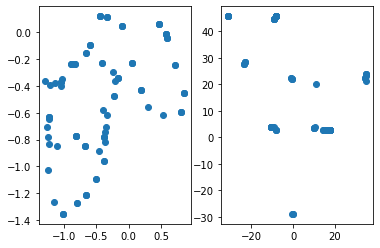

In [26]:
ground_truth_x = pos_x[rat_injection_index]
ground_truth_y = pos_y[rat_injection_index]

noisy_r1 = np.argmax(exc_state_history_per_rep[1:, 0, :], axis = 1) - (N_ex / 2)
noisy_r2 = np.argmax(exc_state_history_per_rep[1:, 1, :], axis = 1) - (N_ex / 2)
noisy_r3 = np.argmax(exc_state_history_per_rep[1:, 2, :], axis = 1) - (N_ex / 2)

print(noisy_r1.shape)

# noisy_r1 = wrap_to_distance(noisy_r1, 120)
# noisy_r2 = wrap_to_distance(noisy_r2, 120)
# noisy_r3 = wrap_to_distance(noisy_r3, 120)

noisy_xy = ring2cart(noisy_r1, noisy_r2, noisy_r3, offset = -90)

fig, ax = plt.subplots(1, 2)

ax[0].scatter(ground_truth_x, ground_truth_y)
ax[1].scatter(noisy_xy[:, 0], noisy_xy[:, 1])

plt.show()

In [27]:
if simulate_or_load == 'simulate':
    
    np.save(f"excitatory_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", np.array([sim.GetStatus(exc_spikes[0]),
                                                                               sim.GetStatus(exc_spikes[1]),
                                                                               sim.GetStatus(exc_spikes[2])]))
    np.save(f"pa_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", np.array([sim.GetStatus(pa_spikes[0]),
                                                                       sim.GetStatus(pa_spikes[1]),
                                                                       sim.GetStatus(pa_spikes[2])]))
    np.save(f"pyramidal_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", sim.GetStatus(pyramidal_spikes))
    
elif simulate_or_load == 'load':
    
    exc_spikes = np.load(f"excitatory_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", allow_pickle = True)
    pa_spikes = np.load(f"pa_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", allow_pickle = True)
    pyramidal_spikes = np.load(f"pyramidal_spikes_{N_pyramidals}_{spiral_or_rat}_{N_ex}_neurons_{int(mins)}_minutes.npy", allow_pickle = True)
    
else:
    
    raise ValueError

## Visualise spikes from run

1538
2251


IndexError: boolean index did not match indexed array along dimension 0; dimension is 9500 but corresponding boolean dimension is 2251

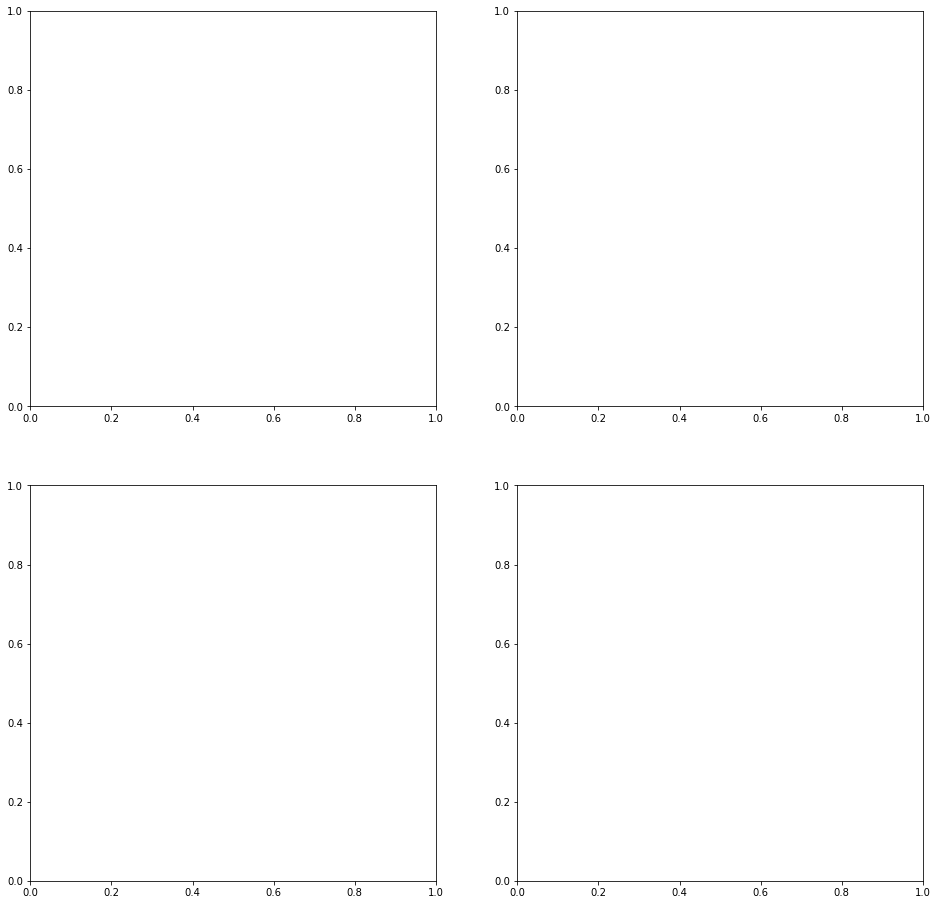

In [28]:
# View pyramidal cell firing

from collections import Counter

# plot #4 comes first, as the most active pyramidal cell is used to index the dataframe of connection details 
# in order to get the relevant ring phase cells responsible

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,16),facecolor='w')

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pyramidal_spikes)[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pyramidal_spikes[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
occurence_count = Counter(sp)
pyramidal_cell = occurence_count.most_common(5)[0][0]

# Below commented code is for if you want to get the relevant pyramidal cell from the 3 constituent ring phase cells

# cell = pa_to_pyramidal_connections[(pa_to_pyramidal_connections["Ring 1 PA Cell"] == ring_1_cell) & 
#                                    (pa_to_pyramidal_connections["Ring 2 PA Cell"] == ring_2_cell) & 
#                                    (pa_to_pyramidal_connections["Ring 3 PA Cell"] == ring_3_cell)
#                                   ]["Target Pyramidal Cell"].tolist()[0]

ring_1_cell = pa_to_pyramidal_connections[pa_to_pyramidal_connections["Target Pyramidal Cell"] == pyramidal_cell]["Ring 1 PA Cell"].tolist()[0]

ring_2_cell = pa_to_pyramidal_connections[pa_to_pyramidal_connections["Target Pyramidal Cell"] == pyramidal_cell]["Ring 2 PA Cell"].tolist()[0]

ring_3_cell = pa_to_pyramidal_connections[pa_to_pyramidal_connections["Target Pyramidal Cell"] == pyramidal_cell]["Ring 3 PA Cell"].tolist()[0]

print(pyramidal_cell)

exc_state_history_per_rep[:, 0, :]

print(len(sp==pyramidal_cell))

spktms = time[sp==pyramidal_cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

print(len(spktms))
print(len(time))

xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax4.set_title("Pyramidal Cells")
ax4.plot(pos_x,pos_y)
ax4.plot(xs,ys,'.')

if spiral_or_rat == 'spiral':

    t = np.arange(0,sim_len,dt)*1.
    time = [i * 1. for i in t if i < sim_len]

elif spiral_or_rat == 'rat':
    
    #t = rat_dataset['post'].squeeze()
    
#     if concatenate_rat:
        
#         t_2 = rat_dataset_2['post'].squeeze()
#         t_2 = t_2 + max(t) + 0.02
#         t = np.concatenate([t, t_2])
        
    # t = t * 1000
    
    time = t

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pa_spikes[0])[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pa_spikes[0][0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
#occurence_count = Counter(sp)
#ring_1_cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==ring_1_cell]
spktms = (spktms//20)*20
spktms=spktms[1:]
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax1.set_title("PA Cells (Y-axis)")
ax1.plot(pos_x,pos_y)
ax1.plot(xs,ys,'.')

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pa_spikes[1])[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pa_spikes[0][0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
#occurence_count = Counter(sp)
#ring_2_cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==ring_2_cell]
spktms = (spktms//20)*20
spktms=spktms[1:]
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax2.set_title("PA Cells (Y_60-axis)")
ax2.plot(pos_x,pos_y)
ax2.plot(xs,ys,'.')

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pa_spikes[2])[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pa_spikes[0][0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

# The most common occurence of cell ID is the most active cell
# This is plotted to see what the maximally active cell is like, to check for any over-excitation
    
#occurence_count = Counter(sp)
#ring_3_cell = occurence_count.most_common(5)[0][0]

spktms = t[sp==ring_3_cell]
spktms = (spktms//20)*20
spktms=spktms[1:]
    
xs = pos_x[np.where(np.isin(time, spktms))]
ys = pos_y[np.where(np.isin(time, spktms))]

ax3.set_title("PA Cells (Y_120-axis)")
ax3.plot(pos_x,pos_y)
ax3.plot(xs,ys,'.')

In [ ]:
# Plot PA ring activity

plot_velocity = False
plot_acceleration = False

fig, axes = plt.subplots(3,1, figsize=(25,24))
grid_fig, grid_axis = plt.subplots(1,1, figsize=(25,8))
grid_axis2 = grid_axis.twinx()

if plot_velocity:

    pyramid_fig, pyramid_axis = plt.subplots(1,1, figsize=(25,8))
    pyramid_axis2 = pyramid_axis.twinx()

if plot_acceleration:

    pyramid_acceleration_fig, pyramid_acceleration_axis = plt.subplots(1,1, figsize=(25,8))
    pyramid_acceleration_axis2 = pyramid_acceleration_axis.twinx()

time_start = 0
time_end = sim_len // 8

colours = ['blue', 'orange', 'green']

graph_time = np.array(time)
graph_time = graph_time[graph_time < time_end][1:]

offsets = [0, Y_plus_60_offset, Y_plus_120_offset]

velocity_components = [Y_input_total[:len(graph_time)], Y_plus_60_input_total[:len(graph_time)], Y_plus_120_input_total[:len(graph_time)]]

for i, colour, axis, offset, velocity_component in zip(range(len(axes)), colours, axes, offsets, velocity_components):
    
    if simulate_or_load == 'simulate':

        ev = sim.GetStatus(pa_spikes[i])[0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    elif simulate_or_load == 'load':

        ev = pa_spikes[i][0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    else:

        raise ValueError
    
    t = t[t < time_end]
    
    neuron_index = sp - np.min(sp)
    
    neuron_index = neuron_index[:len(t)] + i * N_pa_cells_per_ring
    
    ax_twin = axis.twinx()
    
    print(np.mean(np.diff(time)))
    print(velocity_component.shape)
    
    positive_component = velocity_component[velocity_component > 0]
    positive_time = graph_time[velocity_component > 0]
    
    negative_component = velocity_component[velocity_component < 0]
    negative_time = graph_time[velocity_component < 0]
    
    stationary_component = velocity_component[np.abs(velocity_component) < 2]
    stationary_time = graph_time[np.abs(velocity_component) < 2]
    
    axis.scatter(t, neuron_index, alpha = 0.7, c = colour, label = 'PA Cell Spikes')
    ax_twin.scatter(graph_time[20:], velocity_component[20:], c = 'black', label = 'Velocity ?')
    ax_twin.scatter(positive_time[20:], positive_component[20:], alpha = 0.7, c = 'lime', label = 'Velocity +')
    ax_twin.scatter(negative_time[20:], negative_component[20:], alpha = 0.7, c = 'red', label = 'Velocity -')
    ax_twin.scatter(stationary_time[20:], stationary_component[20:], alpha = 0.7, c = 'purple', label = 'Velocity 0')
    axis.set_ylabel("Neuron Index")
    ax_twin.set_ylabel("Velocity")
    axis.set_xlabel("Time (ms)")
    
    axis.set_title(f"Ring {i}")
    
    axis.legend()
    ax_twin.legend(loc = 'upper left')
    
    neuron_index = sp - np.min(sp)
    neuron_index = neuron_index[:len(t)]
    
    grid_axis.scatter(t, neuron_index, alpha = 0.7, c = colour, label = f"Ring {i}")
    
    grid_axis2.scatter(graph_time[20:], velocity_component[20:], c = colour)
    
    grid_axis.legend()
    
combined_components = np.sum(np.array(velocity_components), axis = 0)

grid_axis2.scatter(graph_time[20:],  velocity_magnitude[20:len(graph_time)], c = 'purple', label = 'Original V Mag') 
grid_axis2.scatter(graph_time[20:],  combined_components[20:len(graph_time)], c = 'red',label = 'Sum V Components')
grid_axis2.legend(loc = 'upper left')
grid_axis.set_ylabel("Neuron Index")
grid_axis2.set_ylabel("Velocity")
grid_axis.set_xlabel("Time (ms)")

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pyramidal_spikes)[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
elif simulate_or_load == 'load':

    ev = pyramidal_spikes[0]['events']
    sp = np.array(ev['senders'])
    t = ev['times']
    
else:
    
    raise ValueError

t = t[t < time_end]

if plot_velocity:

    neuron_index = sp - np.min(sp)

    neuron_index = neuron_index[:len(t)]

    pyramid_axis.scatter(t, neuron_index, label = "Grid Cell Spikes")
    pyramid_axis2.plot(graph_time, velocity_components[0], c = colours[0], label = 'Y Velocity')
    pyramid_axis2.plot(graph_time, velocity_components[1], c = colours[1], label = 'Y + 60 Velocity')
    pyramid_axis2.plot(graph_time, velocity_components[2], c = colours[2], label = 'Y + 120 Velocity')
    pyramid_axis2.scatter(graph_time,  velocity_magnitude[:len(graph_time)], c = 'purple', label = 'Original V Mag') 
    pyramid_axis2.scatter(graph_time,  combined_components[:len(graph_time)], c = 'red',label = 'Sum V Components')

    pyramid_axis.set_ylabel("Neuron Index")
    pyramid_axis2.set_ylabel("Velocity")
    pyramid_axis.set_xlabel("Time (ms)")

    pyramid_axis.legend()
    pyramid_axis2.legend(loc = 'upper left')

if plot_acceleration:

    t = t[t < time_end]

    neuron_index = sp - np.min(sp)

    neuron_index = neuron_index[:len(t)]

    acceleration_magnitude = np.diff(velocity_magnitude)

    acceleration_components = [np.diff(x) for x in velocity_components]

    pyramid_acceleration_axis.scatter(t, neuron_index, label = "Grid Cell Spikes")
    pyramid_acceleration_axis2.plot(graph_time[:-1], acceleration_components[0], c = colours[0], label = 'Y Acceleration')
    pyramid_acceleration_axis2.plot(graph_time[:-1], acceleration_components[1], c = colours[1], label = 'Y + 60 Acceleration')
    pyramid_acceleration_axis2.plot(graph_time[:-1], acceleration_components[2], c = colours[2], label = 'Y + 120 Acceleration')
    pyramid_acceleration_axis2.scatter(graph_time[:-1],  acceleration_magnitude[:len(graph_time[:-1])], c = 'purple', label = 'Original Acc Mag')

    pyramid_acceleration_axis.set_ylabel("Neuron Index")
    pyramid_acceleration_axis2.set_ylabel("Acceleration")
    pyramid_acceleration_axis.set_xlabel("Time (ms)")

    pyramid_acceleration_axis.legend()
    pyramid_acceleration_axis2.legend(loc = 'upper left')

In [ ]:
# Plot excitatory ring activity

fig, axes = plt.subplots(3,1, figsize=(25,24))

#time_start = 0
#time_end = sim_len# // 8

colours = ['blue', 'orange', 'green']

offsets = [0, np.radians(60), np.radians(120)]

for i, colour, axis, offset, velocity_component in zip(range(len(axes)), colours, axes, offsets, velocity_components):
    
    if simulate_or_load == 'simulate':

        ev = sim.GetStatus(exc_spikes[i])[0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    elif simulate_or_load == 'load':

        ev = exc_spikes[i][0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    else:

        raise ValueError
    
    neuron_index = sp - np.min(sp)
    
    t = t[t < time_end]
    neuron_index = neuron_index[:len(t)] + i * N_ex
    
    ax_twin = axis.twinx()
    
    positive_component = velocity_component[velocity_component > 0]
    positive_time = graph_time[velocity_component > 0]
    
    negative_component = velocity_component[velocity_component < 0]
    negative_time = graph_time[velocity_component < 0]
    
    stationary_component = velocity_component[np.abs(velocity_component) < 2]
    stationary_time = graph_time[np.abs(velocity_component) < 2]
    
    axis.scatter(t, neuron_index, alpha = 0.7, c = colour)
    ax_twin.scatter(graph_time[20:], velocity_component[20:], c = 'black')
    ax_twin.scatter(positive_time[20:], positive_component[20:], alpha = 0.7, c = 'lime')
    ax_twin.scatter(negative_time[20:], negative_component[20:], alpha = 0.7, c = 'red')
    ax_twin.scatter(stationary_time[20:], stationary_component[20:], alpha = 0.7, c = 'purple')
    
    axis.set_title(f"Ring {i}")

In [ ]:
# Plot excitatory ring activity vs position

from scipy.stats import pearsonr

fig, axes = plt.subplots(3,1, figsize=(25,24))

#time_start = 0
#time_end = sim_len# // 8

colours = ['blue', 'orange', 'green']

offsets = [0, np.radians(60), np.radians(120)]

#Y_input_total_distance = scipy.integrate.cumulative_trapezoid(Y_input_total, dx = 20, initial = 0)#[:len(graph_time)]
#Y_plus_60_input_total_distance = scipy.integrate.cumulative_trapezoid(Y_plus_60_input_total, dx = 20, initial = 0)#[:len(graph_time)]
#Y_plus_120_input_total_distance = scipy.integrate.cumulative_trapezoid(Y_plus_120_input_total, dx = 20, initial = 0)#[:len(graph_time)]

Y_input_total_distance = (np.sin(np.arctan2(pos_y, pos_x) + offsets[0]) * np.sqrt(pos_x ** 2 + pos_y ** 2))[:len(graph_time)]
Y_plus_60_input_total_distance = (np.cos(np.arctan2(pos_y, pos_x) + offsets[1]) * np.sqrt(pos_x ** 2 + pos_y ** 2))[:len(graph_time)]
Y_plus_120_input_total_distance = (np.cos(np.arctan2(pos_y, pos_x) + offsets[2]) * np.sqrt(pos_x ** 2 + pos_y ** 2))[:len(graph_time)]

print(len(Y_input_total))
print(len(Y_input_total_distance))
print(len(graph_time))

distance_components = [Y_input_total_distance, Y_plus_60_input_total_distance, Y_plus_120_input_total_distance]

for i, colour, axis, offset, position_component in zip(range(len(axes)), colours, axes, offsets, distance_components):
    
    print(len(position_component))
    
    if simulate_or_load == 'simulate':

        ev = sim.GetStatus(exc_spikes[i])[0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    elif simulate_or_load == 'load':

        ev = exc_spikes[i][0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    else:

        raise ValueError
    
    neuron_index = sp - np.min(sp)
    
    t = t[t < time_end]
    neuron_index = neuron_index[:len(t)] + i * N_ex
    
    ax_twin = axis.twinx()
    
    positive_component = position_component[position_component > 0]
    positive_time = graph_time[position_component > 0]
    
    negative_component = position_component[position_component < 0]
    negative_time = graph_time[position_component < 0]
    
    stationary_component = position_component[np.abs(position_component) < 2]
    stationary_time = graph_time[np.abs(position_component) < 2]
    
    axis.scatter(t, neuron_index, alpha = 0.7, c = colour)
    ax_twin.scatter(graph_time[20:], position_component[20:], c = 'black')
    ax_twin.scatter(positive_time[20:], positive_component[20:], alpha = 0.7, c = 'lime')
    ax_twin.scatter(negative_time[20:], negative_component[20:], alpha = 0.7, c = 'red')
    ax_twin.scatter(stationary_time[20:], stationary_component[20:], alpha = 0.7, c = 'purple')
    
    axis.set_title(f"Ring {i}")

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(24,16), sharey = True)

#unique_t = np.unique(t)

for i, axis_pair, position_components in zip(range(len(axes.T)), axes.T, distance_components):
    
    if simulate_or_load == 'simulate':

        ev = sim.GetStatus(exc_spikes[i])[0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    elif simulate_or_load == 'load':

        ev = exc_spikes[i][0]['events']
        sp = np.array(ev['senders'])
        t = ev['times']

    else:

        raise ValueError
    
    rounded_timestamps = np.round(t // 20).astype('int') * 20
    
    rounded_unique_timestamps = np.unique(rounded_timestamps)
    
    position_timestamps = np.arange(20, max(rounded_timestamps)+20, step = 20)
    
    #print(position_timestamps)
    
    mean_neuron_index_per_timestep = np.empty(shape = (len(rounded_unique_timestamps)))
    
    #print(rounded_timestamps)
    #print(rounded_unique_timestamps)
    
    neuron_index = sp - np.min(sp)
    
    t = t[t < time_end]
    
    neuron_index = neuron_index[:len(t)] + i * N_ex
    
    for i, timestamp in enumerate(rounded_unique_timestamps):
        
        subset_neurons = neuron_index[rounded_timestamps == timestamp]
        
        mean_neuron_index_per_timestep[i] = np.mean(subset_neurons)
    
    unwrapped_neuron_index = np.unwrap(mean_neuron_index_per_timestep, period = 120)
    
    #unwrapped_neuron_index[unwrapped_neuron_index % np.max(unwrapped_neuron_index) == 0] = unwrapped_neuron_index[unwrapped_neuron_index % np.max(unwrapped_neuron_index) == 0] + (unwrapped_neuron_index[unwrapped_neuron_index % np.max(unwrapped_neuron_index) == 0] - 120)
    
    #print(len(unwrapped_neuron_index))
    #print(unwrapped_neuron_index.shape)
    #print(len(position_component))
    
    #binned_spikes = np.histogram(unwrapped_neuron_index, bins = len(position_component))
    
    positions_with_at_least_one_spike = position_component[np.isin(position_timestamps, rounded_unique_timestamps)]
    
    print(len(positions_with_at_least_one_spike))
    
    result = pearsonr(positions_with_at_least_one_spike, unwrapped_neuron_index)
    
    print(f"Pearson R: {result[0]}, P-Value: {result[1]}")
    
    # To be fair, I think the 'model-fitting' R2 might be more appropriate i.e. Sum Square Residuals/Sum Square Total, since the
    # ring attractor is trying to model the position changes via neural velocity integration
    
    residuals = unwrapped_neuron_index - positions_with_at_least_one_spike
    
    variance = positions_with_at_least_one_spike - np.mean(positions_with_at_least_one_spike)
    
    r2 = 1 - np.sum(residuals ** 2) / np.sum(variance ** 2)
    
    # No, it is meaningless, since the neuron index does not map onto a unit of distance a priori. Representation of distance is
    # an emergent property, so a scaling scalar cannot be used either
    
    #print(f"R-squared: {r2}")
    
    r2_for_subsets = False    
    
    ### Work in progress: trying to calculate R2 for subsets of data, to hopefully show reducing correlation as run progresses (drift)
    
    if r2_for_subsets:
    
        bins = 10

        bin_edges = np.round(np.linspace(0, len(position_component), num = bins+1)).astype('int')[1:]

        print(bin_edges)

        for i, edge in enumerate(bin_edges):

            positions_in_bin = position_component[i*edge:(i+1)*edge]

            #timestamps_in_bin = position_timestamps[i*edge < position_timestamps <= (i+1)*edge]
            timestamps_in_bin = position_timestamps[i*edge:(i+1)*edge]
            #timestamps_in_bin = position_timestamps[(i*edge < position_timestamps) & (position_timestamps <= (i+1)*edge)]

            assert len(positions_in_bin) == len(timestamps_in_bin)

            #rounded_unique_timestamps_in_bin = rounded_unique_timestamps[i*edge < position_timestamps <= (i+1)*edge]
            #rounded_unique_timestamps_in_bin = rounded_unique_timestamps[i*edge:(i+1)*edge]

            rounded_unique_timestamps_in_bin_index = (i*edge < rounded_unique_timestamps) & (rounded_unique_timestamps <= (i+1)*edge)

            rounded_unique_timestamps_in_bin = rounded_unique_timestamps[rounded_unique_timestamps_in_bin_index]

            neurons_in_bin = unwrapped_neuron_index[rounded_unique_timestamps_in_bin_index]

            print(edge)
            print(len(positions_in_bin))
            print(len(timestamps_in_bin))
            print(len(rounded_unique_timestamps_in_bin))
            print(len(neurons_in_bin))

            positions_in_bin_with_at_least_one_spike = positions_in_bin[np.isin(timestamps_in_bin, rounded_unique_timestamps_in_bin)]

            print(len(positions_in_bin_with_at_least_one_spike))

            print(f"Bin {i+1}, R = {pearsonr(positions_in_bin_with_at_least_one_spike, neurons_in_bin)}")
    
    bins = 100
    
    bin_edges = np.round(np.linspace(0, len(position_component), num = bins+1)).astype('int')[1:]
    
    window_length = bin_edges[0]
    
    print(bin_edges)
    
    cumulative_r_value = np.empty(shape = (bins))
    
    for i in range(len(bin_edges)):
        
        cumulative_r_value[i] = pearsonr(positions_with_at_least_one_spike[0:(i+1)*window_length], unwrapped_neuron_index[0:(i+1)*window_length])[0]
        
        #print(cumulative_r_value[i])
        
        #print(f"Bin {i+1}, Sample {i*window_length}:{(i+1)*window_length}, R = {pearsonr(positions_with_at_least_one_spike[0:(i+1)*window_length], unwrapped_neuron_index[0:(i+1)*window_length])}")
    
    mean_cumulative_r = np.round(np.mean(cumulative_r_value), 2)
    
    axis_pair[0].plot(np.arange(0, bins), cumulative_r_value)
    axis_pair[0].axhline(y = mean_cumulative_r, c = 'red')
    axis_pair[0].text(x = np.arange(0, bins)[np.max(bins)//2], y = mean_cumulative_r + 0.02, s = f"Mean: {mean_cumulative_r}")
    
    if i == 0:
        
        axis_pair[0].set_ylabel("Pearson's R, Cumulative")
    
    sliding_r_value = np.empty(shape = (bins))
    
    for i in range(len(bin_edges)):
        
        sliding_r_value[i] = pearsonr(positions_with_at_least_one_spike[i*window_length:(i+1)*window_length], unwrapped_neuron_index[i*window_length:(i+1)*window_length])[0]
    
    mean_sliding_r = np.round(np.mean(sliding_r_value), 2)
    
    axis_pair[1].plot(np.arange(0, bins), sliding_r_value)
    axis_pair[1].axhline(y = mean_sliding_r, c = 'red')
    axis_pair[1].text(x = np.arange(0, bins)[np.max(bins)//2], y = mean_sliding_r + 0.02, s = f"Mean: {mean_sliding_r}")
    axis_pair[1].set_xlabel("Sample")
    
    if i == 0:
        
        axis_pair[0].set_ylabel("Pearson's R, Sliding Window")

In [ ]:
# Plot conjunctive activity

if simulate_or_load == 'simulate':

    fig, axes = plt.subplots(3,1, figsize=(25,24))

    time_start = 0
    time_end = sim_len // 8

    left_colours = ['blue', 'orange', 'green']
    right_colours = ['cyan', 'red', 'lime']

    offsets = [0, np.radians(60), np.radians(120)]

    for i, l_colour, r_colour, axis, offset in zip(range(len(axes)), left_colours, right_colours, axes, offsets):

        ev = sim.GetStatus(left_cj_spikes[i])[0]['events']
        t = ev['times']
        sp = ev['senders']

        neuron_index = sp - np.min(sp)

        t = t[t < time_end]
        neuron_index = neuron_index[:len(t)] + i * N_cj

        ax_twin = axis.twinx()

        velocity_input = velocity_magnitude * np.sin(velocity_angle)

        velocity_component = velocity_input * np.cos(velocity_angle - offset)

        #velocity_component = velocity_component[:len(t)]

        axis.scatter(t, neuron_index, alpha = 0.5, c = l_colour)
        #ax_twin.plot(range(0,len(velocity_component)), velocity_component, c = 'red')

        ev = sim.GetStatus(right_cj_spikes[i])[0]['events']
        t = ev['times']
        sp = ev['senders']

        neuron_index = sp - np.min(sp)

        t = t[t < time_end]
        neuron_index = neuron_index[:len(t)] + i * N_cj

        ax_twin = axis.twinx()

        velocity_input = velocity_magnitude * np.sin(velocity_angle)

        velocity_component = velocity_input * np.cos(velocity_angle - offset)

        #velocity_component = velocity_component[:len(t)]

        axis.scatter(t, neuron_index, alpha = 0.5, c = r_colour)

        axis.set_title(f"Ring {i}")

In [ ]:
# Plot left conjunctive activity with membrane voltage.
# Note that the iaf_psc_alpha model only models sub-threshold dynamics, so the apparent membrane potential will never go above firing threshold
# Despite this, it will still generate spikes

if simulate_or_load == 'simulate':

    from matplotlib import cm

    fig, axes = plt.subplots(3,1, figsize=(25,24))

    time_start = 0
    time_end = sim_len // 8

    colour_index = np.linspace(0, 1, num = 120)
    left_colours = cm.get_cmap('viridis')(colour_index)
    right_colours = cm.get_cmap('plasma')(colour_index)

    for i, l_colour, axis, offset, left_cj_ring in zip(range(len(axes)), left_colours, axes, offsets, l):

        ev = sim.GetStatus(left_cj_voltage[i])[0]['events']
        t = ev['times']
        sp = ev['senders']
        voltage = ev['V_m']

        #for left_cj_index in left_cj_ring:
        if True:

            left_cj_index = left_cj_ring[0]

            target_neuron_indexes = np.argwhere(sp == left_cj_index)

            target_neuron_times = t[target_neuron_indexes]

            target_neuron_voltages = voltage[target_neuron_indexes]

            axis.scatter(target_neuron_times, target_neuron_voltages, alpha = 0.1, color = l_colour)

        ev = sim.GetStatus(left_cj_spikes[i])[0]['events']
        t = ev['times']
        sp = ev['senders']

        ax_twin = axis.twinx()

        neuron_index = sp - np.min(sp)

        neuron_index = neuron_index + i * N_cj

        ax_twin.scatter(t, neuron_index, alpha = 0.1, c = 'red')

        axis.set_title(f"Ring {i}")

In [ ]:
# Plot right conjunctive activity with membrane voltage.
# Note that the iaf_psc_alpha model only models sub-threshold dynamics, so the apparent membrane potential will never go above firing threshold
# Despite this, it will still generate spikes

if simulate_or_load == 'simulate':

    fig, axes = plt.subplots(3,1, figsize=(25,24))

    for i, r_colour, axis, offset, right_cj_ring in zip(range(len(axes)), right_colours, axes, offsets, r):

        ev = sim.GetStatus(right_cj_voltage[i])[0]['events']
        t = ev['times']
        sp = ev['senders']
        voltage = ev['V_m']

        #for right_cj_index in right_cj_ring:
        if True:

            right_cj_index = right_cj_ring[0]

            target_neuron_indexes = np.argwhere(sp == right_cj_index)

            target_neuron_times = t[target_neuron_indexes]

            target_neuron_voltages = voltage[target_neuron_indexes]

            axis.scatter(target_neuron_times, target_neuron_voltages, alpha = 0.1, color = r_colour)

        ev = sim.GetStatus(right_cj_spikes[i])[0]['events']
        t = ev['times']
        sp = ev['senders']

        ax_twin = axis.twinx()

        neuron_index = sp - np.min(sp)

        neuron_index = neuron_index + i * N_cj

        ax_twin.scatter(t, neuron_index, alpha = 0.1, c = 'green')

        axis.set_title(f"Ring {i}")

In [ ]:
# Check for *any* grid cells

if spiral_or_rat == 'spiral':

    t = np.arange(0,sim_len,dt)*1.
    time = [i * 1. for i in t if i < sim_len]
    
elif spiral_or_rat == 'rat':

    t = rat_dataset['post'].squeeze()
    t = t * 1000
    
    time = t

columns = 4

rows = N_pyramidals // columns

plot_anything = True

if rows > 20: # Too many plots ends up larger than the file format can support
    
    rows = 20

if plot_anything is True:
    
    fig, axes = plt.subplots(rows,columns,figsize=(columns * 12, rows * 15),facecolor='w')

    plots = axes.flatten()

if simulate_or_load == 'simulate':

    ev = sim.GetStatus(pyramidal_spikes)[0]['events']
    
elif simulate_or_load == 'load':

    ev = pyramidal_spikes[0]['events']
    
else:
    
    raise ValueError

t = ev['times']
sp = ev['senders']

for i, cell in enumerate(pyramidal_cells):

    spktms1 = t[sp==cell]
    spktms1 = (spktms1//20)*20
    spktms1=spktms1[1:]

    xs = np.empty((len(spktms1)))
    ys = np.empty((len(spktms1)))
        
    xs = pos_x[np.where(np.isin(time, spktms1))]
    ys = pos_y[np.where(np.isin(time, spktms1))]
    
    if plot_anything is True and i < (rows*columns):

        plots[i].set_title("Pyramidal Cell Spiking #{}".format(cell))
        plots[i].plot(pos_x,pos_y)
        plots[i].plot(xs,ys,'.')
        
    print(f"Cell {cell}/{max(pyramidal_cells)} done", end = '\r')

if plot_anything is True:
        
    plt.savefig(f"{rows*columns}_pyramidal_cells.png", bbox_inches = 'tight')

In [ ]:
# Create heatmaps based on spike plots

from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

plot_anything = True

columns = 4

rows = int(np.ceil((N_pyramidals / columns))) #N_pyramidals // rows

if rows > 20: # Too many plots ends up larger than the file format can support
    
    rows = 20

if plot_anything is True:
    
    fig, axes = plt.subplots(rows,columns,figsize=(columns * 15, rows * 15),facecolor='w')

    plots = axes.flatten()

    if 100 < N_pyramidals: # If there are too many plots, they still need to be generated to calculate grid score. Therefore, repeat the axes
                              # so that plots are overwritten as needed

        plots = np.repeat(plots, N_pyramidals // 100)

        for i in range(N_pyramidals % 100):

            plots = np.append(plots, plots[i])

from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.stats import gaussian_kde
from scipy.signal import correlate2d

bin_size_cm = 3 # 3x3cm bins for Sargolini paper
rate_map_sigma = 3

normalised_rate_maps = []

max_cell_index = max(pyramidal_cells)

start = process_time()

for i, cell in enumerate(pyramidal_cells):

    spktms1 = t[sp==cell]
    spktms1 = (spktms1//20)*20
    spktms1=spktms1[1:]
        
    xs = pos_x[np.where(np.isin(time, spktms1))]
    ys = pos_y[np.where(np.isin(time, spktms1))]
    
    bins = int(max(np.sqrt(xs**2 + ys**2)) // bin_size_cm)
    
    if len(xs > 1) and len (ys > 1):
    
        binned_firing = np.histogram2d(-ys/max(-ys), xs/max(xs), bins = bins, density = True)[0]

        smoothed_binned_firing = gaussian_filter(binned_firing, sigma = 3)
        smooth_plot = plots[i].imshow(smoothed_binned_firing, cmap = 'jet')
        
        normalised_rate_map = np.array(smoothed_binned_firing/smoothed_binned_firing.max())
        
        normalised_rate_maps.append(normalised_rate_map)
        
    else:
        
        normalised_rate_map = np.zeros(shape = (bins, bins))
        
        normalised_rate_maps.append(normalised_rate_map)
        
        print(f"Cell {cell} (i = {i}) appears to have no spikes. This may be an error.")
    
    if plot_anything is True:
    
        plots[i].set_title("Pyramidal Cell Rate Heatmap #{}".format(cell))
        plots[i].imshow(binned_firing)
        plots[i].set_axis_off()
    
    print(f"Cell {cell}/{max_cell_index} done", end = '\r')

end = process_time()

print("Time taken: {}".format(end-start))

In [ ]:
# Now turn these into autocorrelograms

from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from scipy.ndimage import shift

plot_anything = True

columns = 4

rows = int(np.ceil((N_pyramidals / columns))) #N_pyramidals // rows

if rows > 20: # Too many plots ends up larger than the file format can support
    
    rows = 20

if plot_anything is True:
    
    fig, axes = plt.subplots(rows,columns,figsize=(columns * 15, rows * 15),facecolor='w')

    plots = axes.flatten()

    if 100 < N_pyramidals: # If there are too many plots, they still need to be generated to calculate grid score. Therefore, repeat the axes
                              # so that plots are overwritten as needed

        plots = np.repeat(plots, N_pyramidals // 100)

        for i in range(N_pyramidals % 100):

            plots = np.append(plots, plots[i])

start = process_time()

for i, normalised_rate_map in enumerate(normalised_rate_maps):

    autocorrelogram = np.zeros(shape = (normalised_rate_map.shape[0] * 2 - 1, normalised_rate_map.shape[1] * 2 - 1))

    for shift_x in range(-normalised_rate_map.shape[0], normalised_rate_map.shape[0]):

        for shift_y in range(-normalised_rate_map.shape[1], normalised_rate_map.shape[1]):

            shifted_rate_map = np.roll(normalised_rate_map, (shift_x, shift_y), axis = (0,1))
            normalised_rate_map_to_shift = normalised_rate_map

            if shift_x == 0 and shift_y == 0:

                normalised_rate_map_shifted = normalised_rate_map_to_shift

            elif shift_x != 0 and shift_y == 0:

                if shift_x < 0:

                    shifted_rate_map = shifted_rate_map[:shift_x, :]
                    normalised_rate_map_shifted = normalised_rate_map_to_shift[:shift_x, :]

                elif shift_x > 0:

                    shifted_rate_map = shifted_rate_map[shift_x:, :]
                    normalised_rate_map_shifted = normalised_rate_map_to_shift[shift_x:, :]

            elif shift_y != 0 and shift_x == 0:

                if shift_y < 0:

                    shifted_rate_map = shifted_rate_map[:, -shift_y:]
                    normalised_rate_map_shifted = normalised_rate_map_to_shift[:, -shift_y:]

                elif shift_y > 0:

                    shifted_rate_map = shifted_rate_map[:, :-shift_y]
                    normalised_rate_map_shifted = normalised_rate_map_to_shift[:, :-shift_y]

            if shift_x != 0 and shift_y != 0:

                if shift_x < 0:

                    shifted_rate_map = shifted_rate_map[:shift_x, :]
                    normalised_rate_map_shifted = normalised_rate_map_to_shift[:shift_x, :]

                elif shift_x > 0:

                    shifted_rate_map = shifted_rate_map[shift_x:, :]
                    normalised_rate_map_shifted = normalised_rate_map_to_shift[shift_x:, :]

                if shift_y < 0:

                    shifted_rate_map = shifted_rate_map[:, -shift_y:]
                    normalised_rate_map_shifted = normalised_rate_map_shifted[:, -shift_y:]

                elif shift_y > 0:

                    shifted_rate_map = shifted_rate_map[:, :-shift_y]
                    normalised_rate_map_shifted = normalised_rate_map_shifted[:, :-shift_y]

            if len(shifted_rate_map.flatten()) > 2:

                correlation = np.cov(normalised_rate_map_shifted.flatten(), shifted_rate_map.flatten())[0][1]

                if correlation < 0.002:

                    correlation = 0

            else:

                correlation = np.nan

            autocorrelogram[shift_x + normalised_rate_map.shape[0]-1, shift_y + normalised_rate_map.shape[1]-1] = correlation
    
    if plot_anything is True:
    
        plots[i].set_title("Pyramidal Cell Rate Heatmap #{}".format(cell))
        plots[i].imshow(autocorrelogram, cmap = 'plasma')
        plots[i].set_axis_off()
    
    print(f"Cell {cell}/{max_cell_index} done", end = '\r')

end = process_time()

print("Time taken: {}".format(end-start))

In [ ]:
# Find some important details for use in the Sargolini gridness score

# Find the central circle of the autocorrelogram
from skimage.filters import threshold_otsu
from skimage import color
from skimage.morphology import binary_erosion, disk
from skimage.filters.rank import maximum
from skimage.feature import peak_local_max

heatmap_size = 4

# fig, ax = plt.subplots(1,1, figsize = (heatmap_size, heatmap_size))

# greyplot = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = 'Greys_r')

# plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
# plt.axis('off')
# plt.axis('image')

# fig = plt.gcf()
# fig.canvas.draw()

# greymap = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

# greymap = greymap.reshape(fig.canvas.get_width_height() + (3,))

# greymap = color.rgb2gray(greymap)

autocorrelogram_mask = autocorrelogram[np.where(np.isnan(autocorrelogram))]

autocorrelogram[np.isnan(autocorrelogram)] = 0

greymap = autocorrelogram

greymap_mask = autocorrelogram_mask

threshold = threshold_otsu(greymap)

binary = greymap > threshold

fig, ax = plt.subplots(1,1, figsize = (heatmap_size, heatmap_size))

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.axis('off')

fig = plt.gcf()
fig.canvas.draw()

ax.imshow(binary, cmap=plt.cm.gray)

fig, ax = plt.subplots(1,1, figsize = (heatmap_size, heatmap_size))

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.axis('off')

fig = plt.gcf()
fig.canvas.draw()

local_maxima = peak_local_max(greymap, num_peaks = 7, min_distance = heatmap_size * 5)

print(local_maxima)

ax.imshow(greymap)

for peak in local_maxima:
    
    y, x = peak
    ax.plot(x, y, 'o')
    
mean_y = int(np.floor(np.mean(local_maxima[:,0])))
mean_x = int(np.floor(np.mean(local_maxima[:,1])))

center_threshold = heatmap_size * 10

for peak in local_maxima:
    
    y, x = peak
    
    if abs(mean_y - y) < center_threshold and abs(mean_x - x) < center_threshold:
        
        center_y = y
        
        center_x = x
        
        break
        
    else:
        
        center_y = mean_y
        
        center_x = mean_x

ax.plot(center_x, center_y, '+')